# 05: Multiple-Patch Model Training
This script implements uniform patching, patch-level training with sample weights, and painting-level aggregation.

## 1. Imports & Dependencies
(imports os, numpy, torch, torchvision, timm, PIL, GroupShuffleSplit)

In [1]:
import os, numpy as np, torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Subset
from torchvision import transforms
import timm
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import GroupShuffleSplit
import torch.nn.utils as U
from collections import defaultdict, Counter
import json
from datetime import datetime
from torch.utils.data import Dataset
from torchvision import transforms
import torch 
from timm.scheduler import CosineLRScheduler
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim
import torch.nn as nn
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
    accuracy_score
)

## 2. Define dataset class producing all patches
(class MultiPatchDataset)

In [2]:
class MultiPatchDataset(Dataset):
    def __init__(self, root_dir, target_size=256, imitation_weight=1.0):
        self.root_dir = root_dir
        self.target_size = target_size
        self.imitation_weight = imitation_weight
        self.defined_classes = ['authentic', 'imitation'] # authentic=0, imitation=1
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.defined_classes)}
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
        print(f"Dataset initialized. Root: '{self.root_dir}', Class mapping: {self.class_to_idx}")

        self.all_patches = [] # Will store (PIL.Image, label, painting_id)
        self._prepare_data()

        self.transform = transforms.Compose([
            transforms.Resize((self.target_size, self.target_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def _prepare_data(self):
        painting_id_counter = 0
        for class_name in self.defined_classes:
            class_path = os.path.join(self.root_dir, class_name)
            if not os.path.isdir(class_path):
                print(f"Warning: Class directory not found: {class_path}")
                continue

            label = self.class_to_idx[class_name]
            
            image_files = sorted([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            if not image_files:
                print(f"Warning: No image files found in {class_path}")
                continue

            for img_filename in image_files:
                img_path = os.path.join(class_path, img_filename)
                current_painting_id = painting_id_counter # All patches from this image get this ID

                try:
                    img = Image.open(img_path).convert('RGB')
                    w, h = img.size
                    max_dim = max(w, h)

                    if max_dim == 0: # Skip zero-size images
                        print(f"Warning: Image {img_path} has zero dimension, skipping.")
                        continue

                    if max_dim > 1024:
                        grid_size = 4  # 4x4 patches
                    elif max_dim >= 512:
                        grid_size = 2  # 2x2 patches
                    else:
                        grid_size = 1  # 1x1 patch

                    patch_width = w // grid_size
                    patch_height = h // grid_size

                    if patch_width == 0 or patch_height == 0: # Skip if patches would be zero-size
                         print(f"Warning: Calculated patch size is zero for {img_path} (w={w},h={h},grid={grid_size}), skipping.")
                         continue

                    for i in range(grid_size):
                        for j in range(grid_size):
                            left = j * patch_width
                            upper = i * patch_height
                            # For the last patch in a row/column, extend to the image edge
                            right = (j + 1) * patch_width if (j + 1) < grid_size else w
                            bottom = (i + 1) * patch_height if (i + 1) < grid_size else h
                            
                            patch_img = img.crop((left, upper, right, bottom))
                            if patch_img.size[0] > 0 and patch_img.size[1] > 0: # Ensure patch is not empty
                                self.all_patches.append((patch_img, label, current_painting_id))
                            else:
                                print(f"Warning: Generated empty patch for {img_path} at grid ({i},{j}), skipping.")
                    
                    painting_id_counter += 1 # Increment for the next distinct artwork

                except UnidentifiedImageError:
                    print(f"Warning: Cannot identify image file {img_path}, skipping.")
                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")
        
        if not self.all_patches:
            print(f"Warning: No patches were generated. Check dataset structure in '{self.root_dir}', paths, and image files.")
        else:
            print(f"Generated {len(self.all_patches)} patches from {painting_id_counter} paintings.")

    def __len__(self):
        return len(self.all_patches)

    def __getitem__(self, idx):
        patch_img, label, painting_id = self.all_patches[idx]
        
        try:
            transformed_patch = self.transform(patch_img)
        except Exception as e:
            print(f"Error transforming patch (original index {idx}, painting_id {painting_id}): {e}")
            # Return a dummy tensor
            transformed_patch = torch.zeros((3, self.target_size, self.target_size), dtype=torch.float32)
            # Keep original label and painting_id
            
        return transformed_patch, label, painting_id

## 3. EffNet Stabilization

In [3]:
class WarmupLRScheduler:
    """Warmup learning rate scheduler for EfficientNet."""
    def __init__(self, optimizer, base_lr=1e-6, warmup_epochs=5, warmup_start_factor=0.1):
        self.optimizer = optimizer
        self.base_lr = base_lr
        self.warmup_epochs = warmup_epochs
        self.warmup_start_factor = warmup_start_factor
        self.current_epoch = 0
        
    def get_lr(self, epoch):
        if epoch < self.warmup_epochs:
            # Linear warmup from start_factor to 1.0
            warmup_progress = epoch / self.warmup_epochs
            factor = self.warmup_start_factor + (1.0 - self.warmup_start_factor) * warmup_progress
            return self.base_lr * factor
        else:
            return self.base_lr
    
    def step(self, epoch):
        self.current_epoch = epoch
        lr = self.get_lr(epoch)
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        return lr

def init_efficientnet_targeted(model):
    """Target only the problematic layers identified from activation analysis."""
    print("Applying targeted weight initialization to problematic EfficientNet layers...")
    
    for name, param in model.named_parameters():
        # Target classifier layers
        if 'classifier' in name and 'weight' in name:
            print(f"  Initializing {name} with very small weights (std=0.001)")
            nn.init.normal_(param, 0, 0.001)
        elif 'classifier' in name and 'bias' in name:
            nn.init.constant_(param, 0)
            
        # Target SE modules
        elif 'se.' in name and 'weight' in name:
            print(f"  Scaling down SE layer: {name}")
            param.data *= 0.1  # Scale down by 90%
            
        # Target problematic Block 6 conv_pw layers
        elif 'blocks.6' in name and 'conv_pw' in name and 'weight' in name:
            print(f"  Scaling down Block 6 conv_pw: {name}")
            param.data *= 0.5  # Scale down by 50%
            
        # Target conv_head
        elif 'conv_head' in name and 'weight' in name:
            print(f"  Scaling down conv_head: {name}")
            param.data *= 0.7  # Moderate scaling
    
    print("Targeted weight initialization complete.")


In [4]:
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

root_dir = '/kaggle/input/vangogh-run1/run_1'  # adjust path as needed
ds = MultiPatchDataset(root_dir, target_size=256, imitation_weight=1.0)
groups = [pid for _, _, pid in ds.all_patches]

# Modified splitting with GroupShuffleSplit for 70/15/15 split
# First split: 70% train, 30% temp (which will be split into 15% val, 15% test)
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, temp_idx = next(gss1.split(ds.all_patches, groups=groups))

# Second split: Split the 30% temp into 15% val and 15% test (50/50 of the temp)
temp_groups = [groups[i] for i in temp_idx]
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=43)
val_idx_temp, test_idx_temp = next(gss2.split([ds.all_patches[i] for i in temp_idx], groups=temp_groups))

# Map back to original indices
val_idx = [temp_idx[i] for i in val_idx_temp]
test_idx = [temp_idx[i] for i in test_idx_temp]

print(f"Train samples: {len(train_idx)} ({len(train_idx)/len(ds.all_patches)*100:.1f}%)")
print(f"Val samples: {len(val_idx)} ({len(val_idx)/len(ds.all_patches)*100:.1f}%)")
print(f"Test samples: {len(test_idx)} ({len(test_idx)/len(ds.all_patches)*100:.1f}%)")
print(f"Classes: {list(ds.class_to_idx.keys())}")

# Excel tracking function with train/val/test flags
excel_path = "/kaggle/input/excel-file-images/vg_cv_data_july31_updated.xlsx"  
sheet_name = 'vg_cv_data_july31'

def track_split_during_processing(excel_path, sheet_name, root_dir, ds, train_idx, val_idx, test_idx):
    print("Updating Excel file with train/val/test split...")
    df = pd.read_excel(excel_path, sheet_name=sheet_name)
    
    df['run_1_split'] = ''
    
    painting_id_to_info = {}
    painting_id_counter = 0
    
    for class_name in ds.defined_classes:
        class_path = Path(root_dir) / class_name
        if not class_path.is_dir():
            continue
            
        image_files = sorted([f for f in class_path.iterdir() 
                            if f.suffix.lower() in ('.png', '.jpg', '.jpeg')])
        
        for img_file in image_files:
            painting_id_to_info[painting_id_counter] = img_file.name
            painting_id_counter += 1
    
    train_painting_ids = {ds.all_patches[idx][2] for idx in train_idx}
    val_painting_ids = {ds.all_patches[idx][2] for idx in val_idx}
    test_painting_ids = {ds.all_patches[idx][2] for idx in test_idx}
    
    train_filenames = {painting_id_to_info[pid] for pid in train_painting_ids if pid in painting_id_to_info}
    val_filenames = {painting_id_to_info[pid] for pid in val_painting_ids if pid in painting_id_to_info}
    test_filenames = {painting_id_to_info[pid] for pid in test_painting_ids if pid in painting_id_to_info}

    for idx, row in df.iterrows():
        image_filename = row['image']
        if image_filename in train_filenames:
            df.loc[idx, 'run_1_split'] = 'train'
        elif image_filename in val_filenames:
            df.loc[idx, 'run_1_split'] = 'val'
        elif image_filename in test_filenames:
            df.loc[idx, 'run_1_split'] = 'test'
    
    # Save updated file
    output_path = '/kaggle/working/vg_cv_data_july31_v1_with_train_val_test_split.xlsx'
    df.to_excel(output_path, sheet_name=sheet_name, index=False)
    
    split_counts = df['run_1_split'].value_counts()
    print(f"Updated Excel saved to: {output_path}")
    print(f"Train/Val/Test split: {dict(split_counts)}")
    
    return output_path

updated_excel = track_split_during_processing(
    excel_path=excel_path,
    sheet_name=sheet_name,
    root_dir=root_dir,
    ds=ds,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx
)

train_dataset = Subset(ds, train_idx)
val_dataset = Subset(ds, val_idx)
test_dataset = Subset(ds, test_idx)  # Reserved for final evaluation only

print(f"Test dataset created with {len(test_dataset)} samples but will NOT be used during training.")

train_labels_for_sampler = np.array([ds.all_patches[i][1] for i in train_idx])
weights = [ds.imitation_weight if label == ds.class_to_idx.get('imitation', 1) else 1 for label in train_labels_for_sampler]
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Calculate class_weights for loss_fn (only from training set)
train_labels_for_class_weights = [ds.all_patches[i][1] for i in train_idx]
class_counts = Counter(train_labels_for_class_weights)
num_classes = len(ds.class_to_idx)

print(f"DEBUG: ds.class_to_idx: {ds.class_to_idx}")
print(f"DEBUG: num_classes: {num_classes}")
print(f"DEBUG: class_counts: {class_counts}")

weights_list = [0.0] * num_classes 

for class_idx, count in class_counts.items():
    if count > 0:
        weights_list[class_idx] = len(train_labels_for_class_weights) / (num_classes * count)
    else:
        weights_list[class_idx] = 1.0

class_weights = torch.tensor(weights_list, dtype=torch.float).to(device)
print(f"Calculated class weights: {class_weights.tolist()}")

Using device: cuda
Dataset initialized. Root: '/kaggle/input/vangogh-run1/run_1', Class mapping: {'authentic': 0, 'imitation': 1}
Generated 20818 patches from 1507 paintings.
Train samples: 14602 (70.1%)
Val samples: 3076 (14.8%)
Test samples: 3140 (15.1%)
Classes: ['authentic', 'imitation']
Updating Excel file with train/val/test split...
Updated Excel saved to: /kaggle/working/vg_cv_data_july31_v1_with_train_val_test_split.xlsx
Train/Val/Test split: {'': 1438, 'train': 1054, 'val': 227, 'test': 227}
Test dataset created with 3140 samples but will NOT be used during training.
DEBUG: ds.class_to_idx: {'authentic': 0, 'imitation': 1}
DEBUG: num_classes: 2
DEBUG: class_counts: Counter({0: 7633, 1: 6969})
Calculated class weights: [0.9565046429634094, 1.0476394891738892]


## 4. Model Setup (EfficientNet & Swin)

In [5]:
print("--- Setting up models with regularization and stabilization ---")

models = {}
# EfficientNet with stabilization
models['efficientnet'] = timm.create_model('efficientnet_b5', pretrained=True, num_classes=2).to(device)
init_efficientnet_targeted(models['efficientnet'])  # Apply targeted initialization

# Regularized Swin Transformer
models['swin'] = timm.create_model(
    'swin_tiny_patch4_window7_224', 
    pretrained=True, 
    num_classes=2, 
    img_size=256,
    drop_rate=0.5,          # Dropout regularization
    drop_path_rate=0.4      # Drop path regularization
).to(device)

# Enhanced loss functions with label smoothing
loss_fn_swin = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.01)
loss_fn_effnet = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.02)

print(f"Swin model configured with regularization: drop_rate=0.5, drop_path_rate=0.4, label_smoothing=0.01")
print(f"EfficientNet configured with label_smoothing=0.02")

# Optimizer for EfficientNet with lower starting LR for stability
eff_optimizer = torch.optim.AdamW(models['efficientnet'].parameters(), lr=1e-7, weight_decay=1e-2)

# --- Differential Learning Rate Setup for Swin Transformer ---
swin_model_instance = models['swin']

# Define Learning Rates for the initial (Frozen Backbone) phase
lr_head_frozen_swin = 3e-5       # Initial LR for the Swin head
lr_backbone_frozen_swin = 0.0    # Backbone is frozen

# Define fine-tuning Learning Rates (more conservative)
swin_lr_head_finetune = 5e-6
swin_lr_backbone_finetune = 1e-6
swin_lr_min_finetune = 5e-7

try:
    # For swin_tiny_patch4_window7_224, the classifier is typically 'head'
    head_params_swin = list(swin_model_instance.head.parameters())
    head_param_ids_swin = {id(p) for p in head_params_swin}
    backbone_params_swin = [p for p in swin_model_instance.parameters() if id(p) not in head_param_ids_swin]

    if not backbone_params_swin:
        print("Warning: Swin backbone parameters list is empty. Check model structure ('head'). Falling back.")
        # Fallback: all params trainable with head_lr
        for param in swin_model_instance.parameters():
            param.requires_grad = True
        swin_optimizer = torch.optim.AdamW(swin_model_instance.parameters(), lr=lr_head_frozen_swin, weight_decay=1e-2)
    else:
        # Freeze backbone layers initially
        for param in backbone_params_swin:
            param.requires_grad = False
        # Ensure head is trainable
        for param in head_params_swin:
            param.requires_grad = True

        swin_optimizer = torch.optim.AdamW([
            {'params': backbone_params_swin, 'lr': lr_backbone_frozen_swin, 'name': 'swin_backbone'},
            {'params': head_params_swin, 'lr': lr_head_frozen_swin, 'name': 'swin_head'}
        ], weight_decay=1e-2)
        print("Swin Transformer Optimizer (Frozen Backbone Phase - DLR) configured.")

except AttributeError:
    print("Error: swin_model_instance.head not found. Cannot separate head/backbone for Swin DLRs automatically.")
    print("Falling back to a single learning rate for all Swin parameters.")
    for param in swin_model_instance.parameters(): # Ensure all params are trainable if fallback
        param.requires_grad = True
    swin_optimizer = torch.optim.AdamW(swin_model_instance.parameters(), lr=lr_head_frozen_swin, weight_decay=1e-2)

optimizers = {
    'efficientnet': eff_optimizer,
    'swin': swin_optimizer
}

# Print optimizer details for verification
for model_name, optimizer in optimizers.items():
    print(f"\nOptimizer for {model_name}:")
    if optimizer: # Check if optimizer was successfully created
        for i, param_group in enumerate(optimizer.param_groups):
            group_name = param_group.get('name', f'group_{i}')
            num_params_in_group = sum(p.numel() for p in param_group['params'] if p.requires_grad)
            total_params_in_group = sum(p.numel() for p in param_group['params'])
            print(f"  Group: {group_name}, LR: {param_group['lr']}, Trainable Params: {num_params_in_group}/{total_params_in_group}, Num Tensors: {len(param_group['params'])}")
            if len(param_group['params']) > 0:
                 print(f"    Sample param requires_grad: {param_group['params'][0].requires_grad}")
    else:
        print(f"  Optimizer for {model_name} not configured (likely due to an error).")
print("--- Model and optimizer setup complete ---")


--- Setting up models with regularization and stabilization ---


model.safetensors:   0%|          | 0.00/122M [00:00<?, ?B/s]

Applying targeted weight initialization to problematic EfficientNet layers...
  Scaling down SE layer: blocks.0.0.se.conv_reduce.weight
  Scaling down SE layer: blocks.0.0.se.conv_expand.weight
  Scaling down SE layer: blocks.0.1.se.conv_reduce.weight
  Scaling down SE layer: blocks.0.1.se.conv_expand.weight
  Scaling down SE layer: blocks.0.2.se.conv_reduce.weight
  Scaling down SE layer: blocks.0.2.se.conv_expand.weight
  Scaling down SE layer: blocks.1.0.se.conv_reduce.weight
  Scaling down SE layer: blocks.1.0.se.conv_expand.weight
  Scaling down SE layer: blocks.1.1.se.conv_reduce.weight
  Scaling down SE layer: blocks.1.1.se.conv_expand.weight
  Scaling down SE layer: blocks.1.2.se.conv_reduce.weight
  Scaling down SE layer: blocks.1.2.se.conv_expand.weight
  Scaling down SE layer: blocks.1.3.se.conv_reduce.weight
  Scaling down SE layer: blocks.1.3.se.conv_expand.weight
  Scaling down SE layer: blocks.1.4.se.conv_reduce.weight
  Scaling down SE layer: blocks.1.4.se.conv_expand.w

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Swin model configured with regularization: drop_rate=0.5, drop_path_rate=0.4, label_smoothing=0.01
EfficientNet configured with label_smoothing=0.02
Swin Transformer Optimizer (Frozen Backbone Phase - DLR) configured.

Optimizer for efficientnet:
  Group: group_0, LR: 1e-07, Trainable Params: 28344882/28344882, Num Tensors: 506
    Sample param requires_grad: True

Optimizer for swin:
  Group: swin_backbone, LR: 0.0, Trainable Params: 0/27519354, Num Tensors: 171
    Sample param requires_grad: False
  Group: swin_head, LR: 3e-05, Trainable Params: 1538/1538, Num Tensors: 2
    Sample param requires_grad: True
--- Model and optimizer setup complete ---


## 5. Logging & Model‐Saving Setup
(make log directory, define timestamp, model_save_paths, log_paths, and log_metrics function)

In [6]:
 
# Ensure log directory exists
os.makedirs('/kaggle/working/Training Data', exist_ok=True)
now_str = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# Define save paths (log_paths removed)
model_save_paths = {
    "efficientnet": f"/kaggle/working/model/efficientnet_b5_finetuned_{now_str}_run1.pth",
    "swin": f"/kaggle/working/model/swin_tiny_patch4_window7_224_finetuned_{now_str}_run1.pth"
}

## 6. Function: save_training_results
(defines saving detailed training/validation metrics to JSON)

In [7]:
def save_training_results(model_name, train_metrics, val_metrics, now_str):
    """Save detailed training results to a JSON file"""
    results = {
        "model_name": model_name,
        "timestamp": now_str,
        "training": train_metrics,
        "validation": val_metrics
    }
    json_path = f"/kaggle/working/Training Data/{model_name}_results_{now_str}_run1.json"
    with open(json_path, 'w') as f:
        json.dump(results, f, indent=4)
    print(f"Detailed results saved to {json_path}")

In [8]:
def train_one_epoch(model, loader, optimizer, loss_fn, epoch=None, print_every=10):
    model.train()
    total_loss, all_preds, all_labels = 0, [], []

    for batch_idx, (x, y, _) in enumerate(loader, start=1):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()

        # Enhanced gradient clipping based on model type
        if hasattr(model, 'default_cfg') and 'swin' in model.default_cfg.get('architecture', '').lower():
            grad_norm = U.clip_grad_norm_(model.parameters(), max_norm=5.0)
        else:
            grad_norm = U.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        total_loss += loss.item() * x.size(0)

        preds = out.argmax(dim=1).cpu().tolist()
        all_preds .extend(preds)
        all_labels.extend(y.cpu().tolist())

        if epoch is not None and batch_idx % print_every == 0:
            print(f"Epoch {epoch+1} | Batch {batch_idx}/{len(loader)} | Loss {loss.item():.6f}")

    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, all_labels, all_preds


## 7. Evaluation with painting-level aggregation
(eval_dataset using defaultdict to average patch logits)

In [9]:
# 7. Evaluation with painting-level aggregation

def eval_dataset_with_loss(model, loader, loss_fn):
    model.eval()
    group_logits = defaultdict(list)
    group_labels = {}
    total_loss = 0
    total_samples = 0
    
    with torch.no_grad():
        for x, y, pid in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            
            # Calculate loss for this batch
            batch_loss = loss_fn(logits, y)
            total_loss += batch_loss.item() * x.size(0)
            total_samples += x.size(0)
            
            # Continue with painting-level aggregation
            logits_cpu = logits.cpu()
            for lg, yy, id_ in zip(logits_cpu, y.cpu(), pid):
                group_logits[id_].append(lg)
                group_labels[id_] = int(yy)

    # Calculate average loss
    avg_loss = total_loss / total_samples
    
    # Sample predictions (first 5)
    for pid, lgs in list(group_logits.items())[:5]:
        avg = torch.stack(lgs).mean(0)
        print(f"Painting {pid}: logits={avg.tolist()}, pred={int(avg.argmax())}, true={group_labels[pid]}")

    # Class balance print
    y_true = list(group_labels.values())
    print(f"Validation class distribution: {sum(y_true)}/{len(y_true)} positives")

    # Compute painting-level accuracy
    y_pred = [int(torch.stack(lgs).mean(0).argmax()) for lgs in group_logits.values()]
    acc = sum(yt==yp for yt, yp in zip(y_true, y_pred)) / len(y_true)
    
    return acc, avg_loss

## 8. Training loop (patch-level)
(defines train_one_epoch and loops over models to train, log, save checkpoints, and call save_training_results)

--- Configuring Schedulers ---
  EfficientNet will use warmup scheduler first, then ReduceLROnPlateau.
  Scheduler for 'swin' will be initialized during unfreeze.
--- Schedulers configured ---

--- Starting Training for 30 Epochs ---

===== EPOCH 1/30 =====

Training efficientnet for Epoch 1...
  EfficientNet warmup LR: 1.00e-07
  Current LRs for efficientnet:
    Group 'group_0': 1.00e-07
Epoch 1 | Batch 50/913 | Loss 0.697616
Epoch 1 | Batch 100/913 | Loss 0.687499
Epoch 1 | Batch 150/913 | Loss 0.687141
Epoch 1 | Batch 200/913 | Loss 0.692417
Epoch 1 | Batch 250/913 | Loss 0.692907
Epoch 1 | Batch 300/913 | Loss 0.689552
Epoch 1 | Batch 350/913 | Loss 0.693961
Epoch 1 | Batch 400/913 | Loss 0.684124
Epoch 1 | Batch 450/913 | Loss 0.686087
Epoch 1 | Batch 500/913 | Loss 0.693590
Epoch 1 | Batch 550/913 | Loss 0.677506
Epoch 1 | Batch 600/913 | Loss 0.686511
Epoch 1 | Batch 650/913 | Loss 0.685671
Epoch 1 | Batch 700/913 | Loss 0.691174
Epoch 1 | Batch 750/913 | Loss 0.677869
Epoch 1 

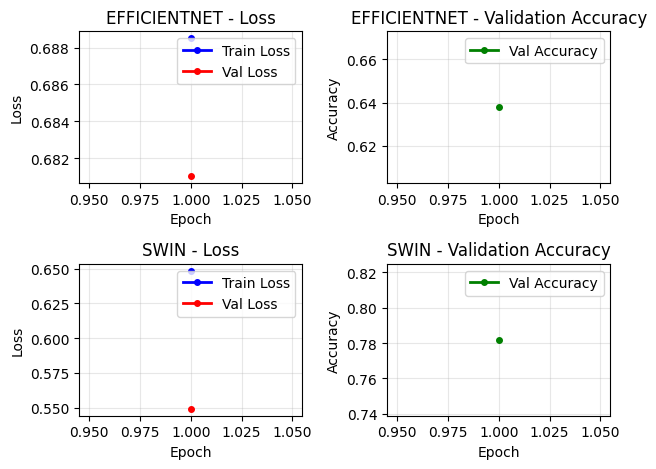


===== EPOCH 2/30 =====

Training efficientnet for Epoch 2...
  EfficientNet warmup LR: 2.80e-07
  Current LRs for efficientnet:
    Group 'group_0': 2.80e-07
Epoch 2 | Batch 50/913 | Loss 0.682049
Epoch 2 | Batch 100/913 | Loss 0.672886
Epoch 2 | Batch 150/913 | Loss 0.677911
Epoch 2 | Batch 200/913 | Loss 0.685455
Epoch 2 | Batch 250/913 | Loss 0.678635
Epoch 2 | Batch 300/913 | Loss 0.669505
Epoch 2 | Batch 350/913 | Loss 0.655141
Epoch 2 | Batch 400/913 | Loss 0.728523
Epoch 2 | Batch 450/913 | Loss 0.668651
Epoch 2 | Batch 500/913 | Loss 0.668654
Epoch 2 | Batch 550/913 | Loss 0.701815
Epoch 2 | Batch 600/913 | Loss 0.619658
Epoch 2 | Batch 650/913 | Loss 0.648965
Epoch 2 | Batch 700/913 | Loss 0.673686
Epoch 2 | Batch 750/913 | Loss 0.626099
Epoch 2 | Batch 800/913 | Loss 0.628193
Epoch 2 | Batch 850/913 | Loss 0.604307
Epoch 2 | Batch 900/913 | Loss 0.729561
Validating efficientnet for Epoch 2...
RESULTS: efficientnet | Epoch 2/30 | Train Loss: 0.659791 | Val Acc: 0.718466

Trai

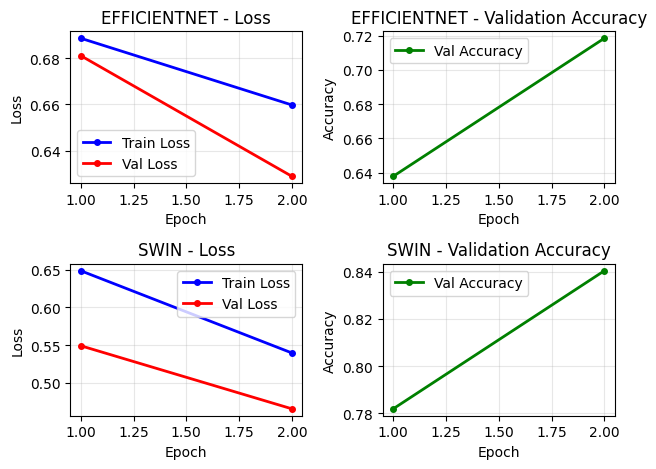


===== EPOCH 3/30 =====

Training efficientnet for Epoch 3...
  EfficientNet warmup LR: 4.60e-07
  Current LRs for efficientnet:
    Group 'group_0': 4.60e-07
Epoch 3 | Batch 50/913 | Loss 0.655618
Epoch 3 | Batch 100/913 | Loss 0.640213
Epoch 3 | Batch 150/913 | Loss 0.587314
Epoch 3 | Batch 200/913 | Loss 0.582336
Epoch 3 | Batch 250/913 | Loss 0.575078
Epoch 3 | Batch 300/913 | Loss 0.678758
Epoch 3 | Batch 350/913 | Loss 0.664892
Epoch 3 | Batch 400/913 | Loss 0.640937
Epoch 3 | Batch 450/913 | Loss 0.626201
Epoch 3 | Batch 500/913 | Loss 0.519557
Epoch 3 | Batch 550/913 | Loss 0.605444
Epoch 3 | Batch 600/913 | Loss 0.571566
Epoch 3 | Batch 650/913 | Loss 0.551585
Epoch 3 | Batch 700/913 | Loss 0.551003
Epoch 3 | Batch 750/913 | Loss 0.526335
Epoch 3 | Batch 800/913 | Loss 0.557015
Epoch 3 | Batch 850/913 | Loss 0.578004
Epoch 3 | Batch 900/913 | Loss 0.541754
Validating efficientnet for Epoch 3...
RESULTS: efficientnet | Epoch 3/30 | Train Loss: 0.590636 | Val Acc: 0.789662

Trai

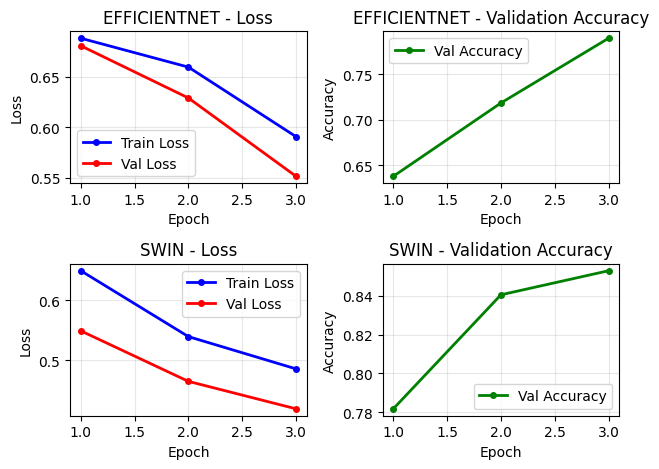


===== EPOCH 4/30 =====

Training efficientnet for Epoch 4...
  EfficientNet warmup LR: 6.40e-07
  Current LRs for efficientnet:
    Group 'group_0': 6.40e-07
Epoch 4 | Batch 50/913 | Loss 0.510565
Epoch 4 | Batch 100/913 | Loss 0.516704
Epoch 4 | Batch 150/913 | Loss 0.465514
Epoch 4 | Batch 200/913 | Loss 0.601654
Epoch 4 | Batch 250/913 | Loss 0.585786
Epoch 4 | Batch 300/913 | Loss 0.547514
Epoch 4 | Batch 350/913 | Loss 0.525557
Epoch 4 | Batch 400/913 | Loss 0.487027
Epoch 4 | Batch 450/913 | Loss 0.597302
Epoch 4 | Batch 500/913 | Loss 0.675849
Epoch 4 | Batch 550/913 | Loss 0.550973
Epoch 4 | Batch 600/913 | Loss 0.456472
Epoch 4 | Batch 650/913 | Loss 0.503708
Epoch 4 | Batch 700/913 | Loss 0.508160
Epoch 4 | Batch 750/913 | Loss 0.496989
Epoch 4 | Batch 800/913 | Loss 0.506626
Epoch 4 | Batch 850/913 | Loss 0.571249
Epoch 4 | Batch 900/913 | Loss 0.441009
Validating efficientnet for Epoch 4...
RESULTS: efficientnet | Epoch 4/30 | Train Loss: 0.528765 | Val Acc: 0.824122

Trai

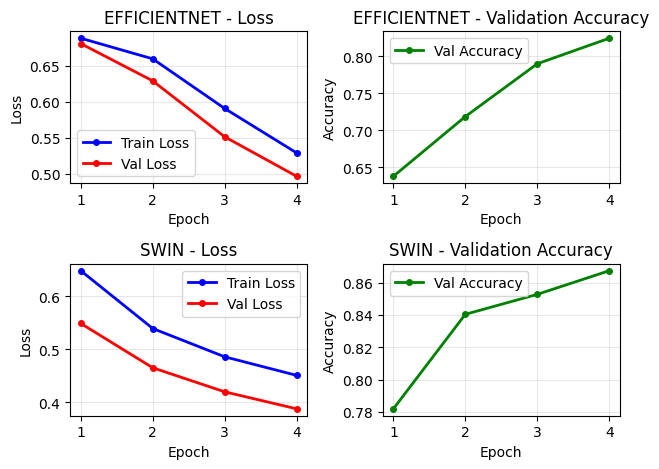


===== EPOCH 5/30 =====

Training efficientnet for Epoch 5...
  EfficientNet warmup LR: 8.20e-07
  Current LRs for efficientnet:
    Group 'group_0': 8.20e-07
Epoch 5 | Batch 50/913 | Loss 0.474340
Epoch 5 | Batch 100/913 | Loss 0.464359
Epoch 5 | Batch 150/913 | Loss 0.468240
Epoch 5 | Batch 200/913 | Loss 0.495182
Epoch 5 | Batch 250/913 | Loss 0.480836
Epoch 5 | Batch 300/913 | Loss 0.403052
Epoch 5 | Batch 350/913 | Loss 0.437489
Epoch 5 | Batch 400/913 | Loss 0.524342
Epoch 5 | Batch 450/913 | Loss 0.451938
Epoch 5 | Batch 500/913 | Loss 0.681513
Epoch 5 | Batch 550/913 | Loss 0.468814
Epoch 5 | Batch 600/913 | Loss 0.375352
Epoch 5 | Batch 650/913 | Loss 0.646362
Epoch 5 | Batch 700/913 | Loss 0.722548
Epoch 5 | Batch 750/913 | Loss 0.501612
Epoch 5 | Batch 800/913 | Loss 0.546745
Epoch 5 | Batch 850/913 | Loss 0.343894
Epoch 5 | Batch 900/913 | Loss 0.406083
Validating efficientnet for Epoch 5...
RESULTS: efficientnet | Epoch 5/30 | Train Loss: 0.471309 | Val Acc: 0.846554

Trai

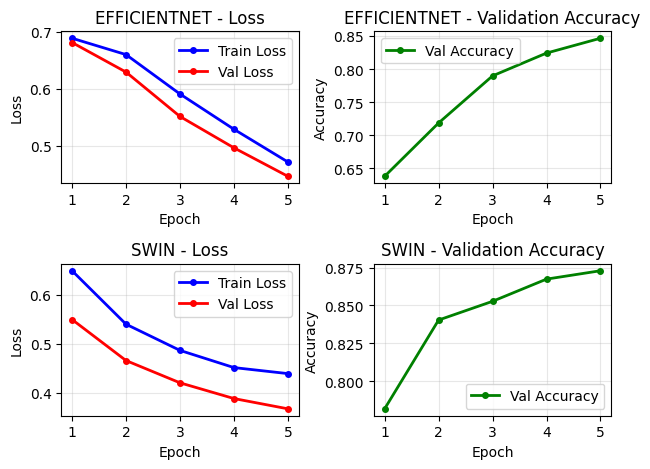


===== EPOCH 6/30 =====

-- Epoch 6: Unfreezing Swin Transformer backbone and adjusting LRs for fine-tuning. --
  Setting requires_grad=True for all Swin model parameters...
    All Swin model parameters set to requires_grad=True.
  LR for Swin group 'swin_backbone' set to: 1.00e-06
  LR for Swin group 'swin_head' set to: 5.00e-06
  Initializing CosineLRScheduler for Swin fine-tuning...
  Swin CosineLRScheduler initialized for 25 fine-tuning epochs.
-- Swin unfreezing and LR adjustment complete. --

Training efficientnet for Epoch 6...
  Warmup complete! Switching to ReduceLROnPlateau scheduler...
  Current LRs for efficientnet:
    Group 'group_0': 8.20e-07


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 6 | Batch 50/913 | Loss 0.399005
Epoch 6 | Batch 100/913 | Loss 0.350039
Epoch 6 | Batch 150/913 | Loss 0.340270
Epoch 6 | Batch 200/913 | Loss 0.487124
Epoch 6 | Batch 250/913 | Loss 0.363111
Epoch 6 | Batch 300/913 | Loss 0.317735
Epoch 6 | Batch 350/913 | Loss 0.447416
Epoch 6 | Batch 400/913 | Loss 0.391338
Epoch 6 | Batch 450/913 | Loss 0.408971
Epoch 6 | Batch 500/913 | Loss 0.309466
Epoch 6 | Batch 550/913 | Loss 0.560851
Epoch 6 | Batch 600/913 | Loss 0.255692
Epoch 6 | Batch 650/913 | Loss 0.607576
Epoch 6 | Batch 700/913 | Loss 0.354093
Epoch 6 | Batch 750/913 | Loss 0.259922
Epoch 6 | Batch 800/913 | Loss 0.363346
Epoch 6 | Batch 850/913 | Loss 0.433978
Epoch 6 | Batch 900/913 | Loss 0.334775
Validating efficientnet for Epoch 6...
RESULTS: efficientnet | Epoch 6/30 | Train Loss: 0.407325 | Val Acc: 0.873862

Training swin for Epoch 6...
  Current LRs for swin:
    Group 'swin_backbone': 1.00e-06
    Group 'swin_head': 1.00e-06
Epoch 6 | Batch 50/913 | Loss 0.251295
Epo

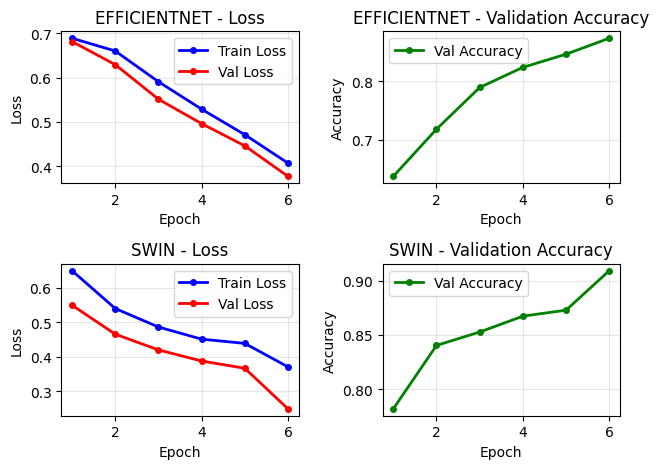


===== EPOCH 7/30 =====

Training efficientnet for Epoch 7...
  Current LRs for efficientnet:
    Group 'group_0': 8.20e-07
Epoch 7 | Batch 50/913 | Loss 0.389396
Epoch 7 | Batch 100/913 | Loss 0.361947
Epoch 7 | Batch 150/913 | Loss 0.315587
Epoch 7 | Batch 200/913 | Loss 0.276667
Epoch 7 | Batch 250/913 | Loss 0.361259
Epoch 7 | Batch 300/913 | Loss 0.262886
Epoch 7 | Batch 350/913 | Loss 0.252931
Epoch 7 | Batch 400/913 | Loss 0.332643
Epoch 7 | Batch 450/913 | Loss 0.237018
Epoch 7 | Batch 500/913 | Loss 0.215043
Epoch 7 | Batch 550/913 | Loss 0.418860
Epoch 7 | Batch 600/913 | Loss 0.275560
Epoch 7 | Batch 650/913 | Loss 0.254628
Epoch 7 | Batch 700/913 | Loss 0.228695
Epoch 7 | Batch 750/913 | Loss 0.232149
Epoch 7 | Batch 800/913 | Loss 0.225216
Epoch 7 | Batch 850/913 | Loss 0.203872
Epoch 7 | Batch 900/913 | Loss 0.391276
Validating efficientnet for Epoch 7...
RESULTS: efficientnet | Epoch 7/30 | Train Loss: 0.351774 | Val Acc: 0.884590

Training swin for Epoch 7...
  Current 

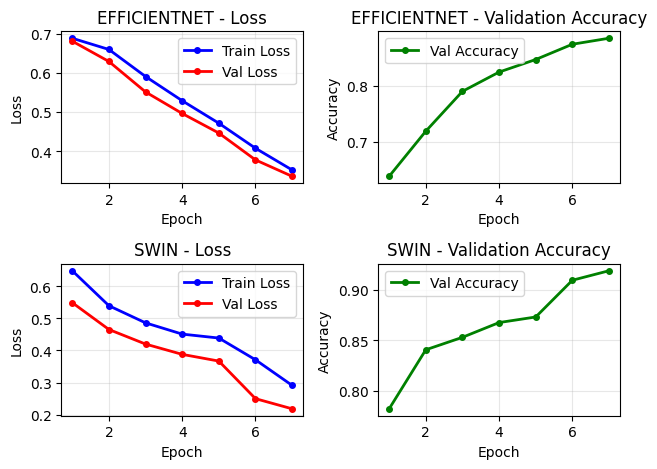


===== EPOCH 8/30 =====

Training efficientnet for Epoch 8...
  Current LRs for efficientnet:
    Group 'group_0': 8.20e-07
Epoch 8 | Batch 50/913 | Loss 0.257102
Epoch 8 | Batch 100/913 | Loss 0.247116
Epoch 8 | Batch 150/913 | Loss 0.350674
Epoch 8 | Batch 200/913 | Loss 0.430669
Epoch 8 | Batch 250/913 | Loss 0.260992
Epoch 8 | Batch 300/913 | Loss 0.185376
Epoch 8 | Batch 350/913 | Loss 0.379423
Epoch 8 | Batch 400/913 | Loss 0.265751
Epoch 8 | Batch 450/913 | Loss 0.448584
Epoch 8 | Batch 500/913 | Loss 0.261316
Epoch 8 | Batch 550/913 | Loss 0.332922
Epoch 8 | Batch 600/913 | Loss 0.503975
Epoch 8 | Batch 650/913 | Loss 0.258557
Epoch 8 | Batch 700/913 | Loss 0.130633
Epoch 8 | Batch 750/913 | Loss 0.238695
Epoch 8 | Batch 800/913 | Loss 0.228035
Epoch 8 | Batch 850/913 | Loss 0.194532
Epoch 8 | Batch 900/913 | Loss 0.308110
Validating efficientnet for Epoch 8...
RESULTS: efficientnet | Epoch 8/30 | Train Loss: 0.318153 | Val Acc: 0.892718

Training swin for Epoch 8...
  Current 

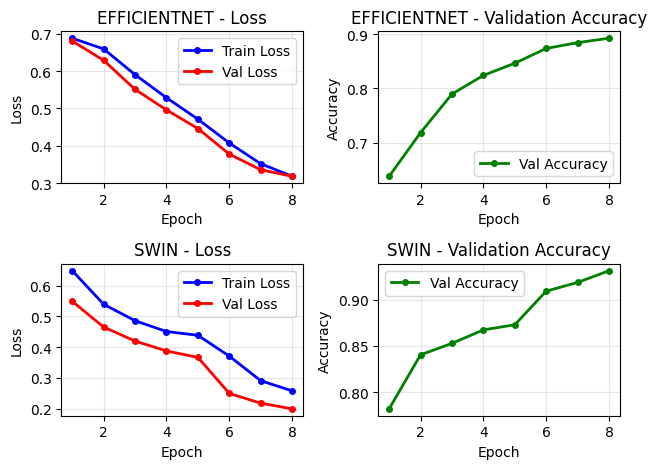


===== EPOCH 9/30 =====

Training efficientnet for Epoch 9...
  Current LRs for efficientnet:
    Group 'group_0': 8.20e-07
Epoch 9 | Batch 50/913 | Loss 0.234574
Epoch 9 | Batch 100/913 | Loss 0.280015
Epoch 9 | Batch 150/913 | Loss 0.206658
Epoch 9 | Batch 200/913 | Loss 0.263249
Epoch 9 | Batch 250/913 | Loss 0.294257
Epoch 9 | Batch 300/913 | Loss 0.149662
Epoch 9 | Batch 350/913 | Loss 0.211018
Epoch 9 | Batch 400/913 | Loss 0.346035
Epoch 9 | Batch 450/913 | Loss 0.154168
Epoch 9 | Batch 500/913 | Loss 0.309919
Epoch 9 | Batch 550/913 | Loss 0.342393
Epoch 9 | Batch 600/913 | Loss 0.518015
Epoch 9 | Batch 650/913 | Loss 0.354905
Epoch 9 | Batch 700/913 | Loss 0.159889
Epoch 9 | Batch 750/913 | Loss 0.249960
Epoch 9 | Batch 800/913 | Loss 0.155379
Epoch 9 | Batch 850/913 | Loss 0.127387
Epoch 9 | Batch 900/913 | Loss 0.606297
Validating efficientnet for Epoch 9...
RESULTS: efficientnet | Epoch 9/30 | Train Loss: 0.294857 | Val Acc: 0.897269

Training swin for Epoch 9...
  Current 

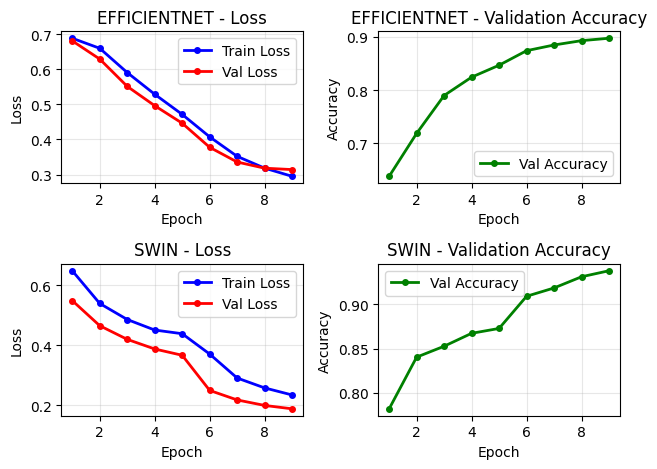


===== EPOCH 10/30 =====

Training efficientnet for Epoch 10...
  Current LRs for efficientnet:
    Group 'group_0': 8.20e-07
Epoch 10 | Batch 50/913 | Loss 0.317143
Epoch 10 | Batch 100/913 | Loss 0.183850
Epoch 10 | Batch 150/913 | Loss 0.184837
Epoch 10 | Batch 200/913 | Loss 0.222029
Epoch 10 | Batch 250/913 | Loss 0.295104
Epoch 10 | Batch 300/913 | Loss 0.305064
Epoch 10 | Batch 350/913 | Loss 0.204518
Epoch 10 | Batch 400/913 | Loss 0.157306
Epoch 10 | Batch 450/913 | Loss 0.380771
Epoch 10 | Batch 500/913 | Loss 0.282169
Epoch 10 | Batch 550/913 | Loss 0.142040
Epoch 10 | Batch 600/913 | Loss 0.354245
Epoch 10 | Batch 650/913 | Loss 0.149424
Epoch 10 | Batch 700/913 | Loss 0.389903
Epoch 10 | Batch 750/913 | Loss 0.229920
Epoch 10 | Batch 800/913 | Loss 0.096813
Epoch 10 | Batch 850/913 | Loss 0.153141
Epoch 10 | Batch 900/913 | Loss 0.256574
Validating efficientnet for Epoch 10...
RESULTS: efficientnet | Epoch 10/30 | Train Loss: 0.272069 | Val Acc: 0.900845

Training swin for

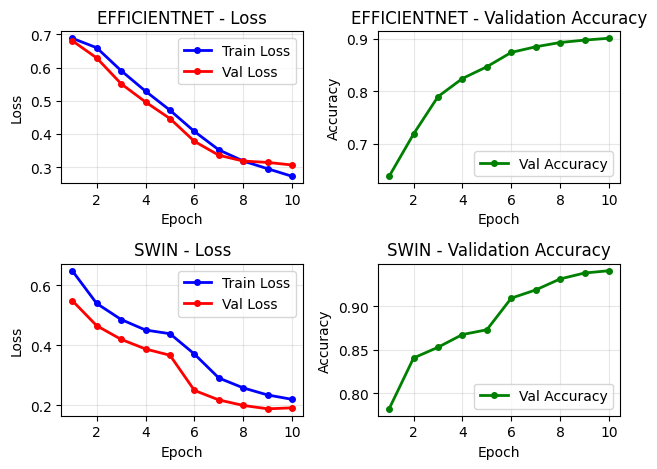


===== EPOCH 11/30 =====

Training efficientnet for Epoch 11...
  Current LRs for efficientnet:
    Group 'group_0': 8.20e-07
Epoch 11 | Batch 50/913 | Loss 0.251272
Epoch 11 | Batch 100/913 | Loss 0.140829
Epoch 11 | Batch 150/913 | Loss 0.289439
Epoch 11 | Batch 200/913 | Loss 0.360144
Epoch 11 | Batch 250/913 | Loss 0.189085
Epoch 11 | Batch 300/913 | Loss 0.326937
Epoch 11 | Batch 350/913 | Loss 0.555704
Epoch 11 | Batch 400/913 | Loss 0.491307
Epoch 11 | Batch 450/913 | Loss 0.117892
Epoch 11 | Batch 500/913 | Loss 0.716409
Epoch 11 | Batch 550/913 | Loss 0.418918
Epoch 11 | Batch 600/913 | Loss 0.379975
Epoch 11 | Batch 650/913 | Loss 0.255919
Epoch 11 | Batch 700/913 | Loss 0.253527
Epoch 11 | Batch 750/913 | Loss 0.157754
Epoch 11 | Batch 800/913 | Loss 0.168878
Epoch 11 | Batch 850/913 | Loss 0.142448
Epoch 11 | Batch 900/913 | Loss 0.177012
Validating efficientnet for Epoch 11...
RESULTS: efficientnet | Epoch 11/30 | Train Loss: 0.259376 | Val Acc: 0.907347

Training swin for

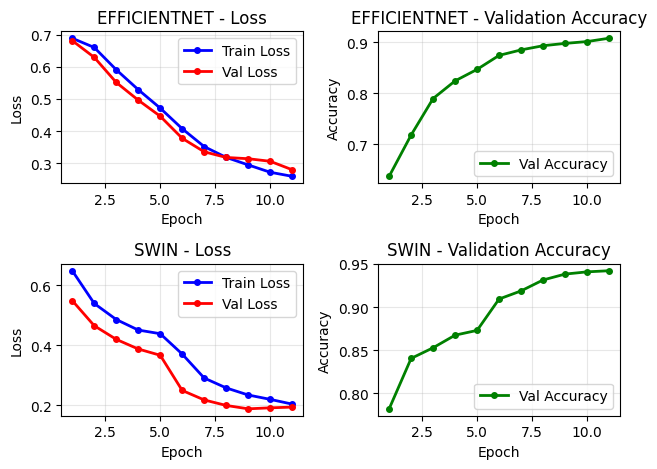


===== EPOCH 12/30 =====

Training efficientnet for Epoch 12...
  Current LRs for efficientnet:
    Group 'group_0': 8.20e-07
Epoch 12 | Batch 50/913 | Loss 0.120886
Epoch 12 | Batch 100/913 | Loss 0.313258
Epoch 12 | Batch 150/913 | Loss 0.345919
Epoch 12 | Batch 200/913 | Loss 0.106349
Epoch 12 | Batch 250/913 | Loss 0.282059
Epoch 12 | Batch 300/913 | Loss 0.208000
Epoch 12 | Batch 350/913 | Loss 0.327953
Epoch 12 | Batch 400/913 | Loss 0.384534
Epoch 12 | Batch 450/913 | Loss 0.092464
Epoch 12 | Batch 500/913 | Loss 0.113661
Epoch 12 | Batch 550/913 | Loss 0.826099
Epoch 12 | Batch 600/913 | Loss 0.316534
Epoch 12 | Batch 650/913 | Loss 0.226314
Epoch 12 | Batch 700/913 | Loss 0.135186
Epoch 12 | Batch 750/913 | Loss 0.358769
Epoch 12 | Batch 800/913 | Loss 0.222760
Epoch 12 | Batch 850/913 | Loss 0.115223
Epoch 12 | Batch 900/913 | Loss 0.140790
Validating efficientnet for Epoch 12...
RESULTS: efficientnet | Epoch 12/30 | Train Loss: 0.234452 | Val Acc: 0.913524

Training swin for

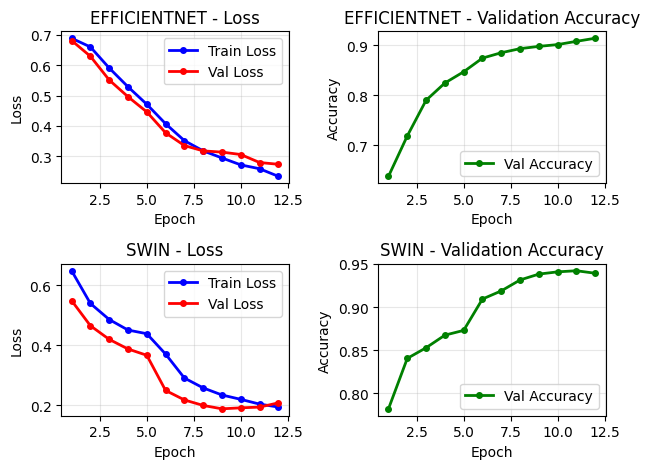


===== EPOCH 13/30 =====

Training efficientnet for Epoch 13...
  Current LRs for efficientnet:
    Group 'group_0': 8.20e-07
Epoch 13 | Batch 50/913 | Loss 0.151428
Epoch 13 | Batch 100/913 | Loss 0.160147
Epoch 13 | Batch 150/913 | Loss 0.151639
Epoch 13 | Batch 200/913 | Loss 0.165467
Epoch 13 | Batch 250/913 | Loss 0.720229
Epoch 13 | Batch 300/913 | Loss 0.161714
Epoch 13 | Batch 350/913 | Loss 0.145625
Epoch 13 | Batch 400/913 | Loss 0.727403
Epoch 13 | Batch 450/913 | Loss 0.226295
Epoch 13 | Batch 500/913 | Loss 0.191453
Epoch 13 | Batch 550/913 | Loss 0.128275
Epoch 13 | Batch 600/913 | Loss 0.214397
Epoch 13 | Batch 650/913 | Loss 0.244461
Epoch 13 | Batch 700/913 | Loss 0.246663
Epoch 13 | Batch 750/913 | Loss 0.293643
Epoch 13 | Batch 800/913 | Loss 0.251876
Epoch 13 | Batch 850/913 | Loss 0.298210
Epoch 13 | Batch 900/913 | Loss 0.214500
Validating efficientnet for Epoch 13...
RESULTS: efficientnet | Epoch 13/30 | Train Loss: 0.220210 | Val Acc: 0.905397

Training swin for

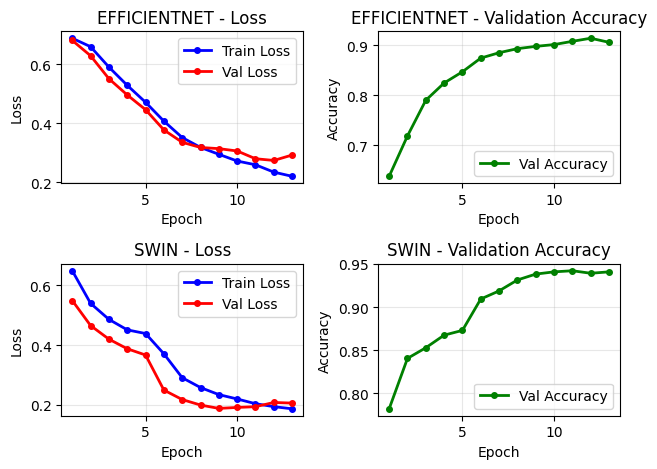


===== EPOCH 14/30 =====

Training efficientnet for Epoch 14...
  Current LRs for efficientnet:
    Group 'group_0': 8.20e-07
Epoch 14 | Batch 50/913 | Loss 0.105886
Epoch 14 | Batch 100/913 | Loss 0.093794
Epoch 14 | Batch 150/913 | Loss 0.114555
Epoch 14 | Batch 200/913 | Loss 0.167693
Epoch 14 | Batch 250/913 | Loss 0.325651
Epoch 14 | Batch 300/913 | Loss 0.091142
Epoch 14 | Batch 350/913 | Loss 0.476403
Epoch 14 | Batch 400/913 | Loss 0.323651
Epoch 14 | Batch 450/913 | Loss 0.138855
Epoch 14 | Batch 500/913 | Loss 0.262694
Epoch 14 | Batch 550/913 | Loss 0.089960
Epoch 14 | Batch 600/913 | Loss 0.486913
Epoch 14 | Batch 650/913 | Loss 0.246544
Epoch 14 | Batch 700/913 | Loss 0.192784
Epoch 14 | Batch 750/913 | Loss 0.241967
Epoch 14 | Batch 800/913 | Loss 0.091455
Epoch 14 | Batch 850/913 | Loss 0.132479
Epoch 14 | Batch 900/913 | Loss 0.392176
Validating efficientnet for Epoch 14...
RESULTS: efficientnet | Epoch 14/30 | Train Loss: 0.216179 | Val Acc: 0.907672

Training swin for

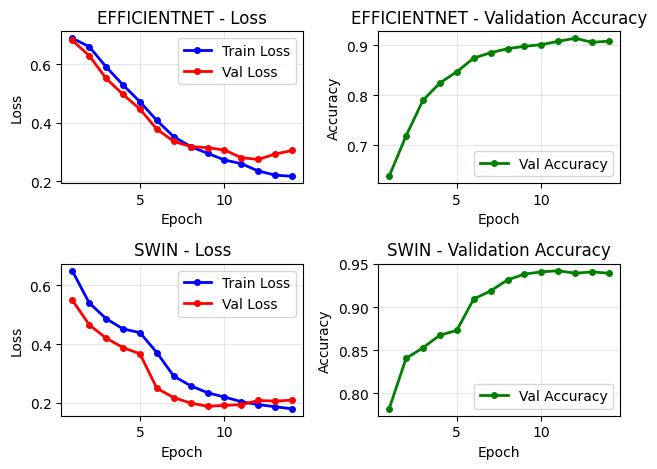


===== EPOCH 15/30 =====

Training efficientnet for Epoch 15...
  Current LRs for efficientnet:
    Group 'group_0': 8.20e-07
Epoch 15 | Batch 50/913 | Loss 0.113336
Epoch 15 | Batch 100/913 | Loss 0.170279
Epoch 15 | Batch 150/913 | Loss 0.241493
Epoch 15 | Batch 200/913 | Loss 0.206773
Epoch 15 | Batch 250/913 | Loss 0.182395
Epoch 15 | Batch 300/913 | Loss 0.141325
Epoch 15 | Batch 350/913 | Loss 0.135949
Epoch 15 | Batch 400/913 | Loss 0.090619
Epoch 15 | Batch 450/913 | Loss 0.154376
Epoch 15 | Batch 500/913 | Loss 0.346001
Epoch 15 | Batch 550/913 | Loss 0.096220
Epoch 15 | Batch 600/913 | Loss 0.386825
Epoch 15 | Batch 650/913 | Loss 0.446608
Epoch 15 | Batch 700/913 | Loss 0.261730
Epoch 15 | Batch 750/913 | Loss 0.080759
Epoch 15 | Batch 800/913 | Loss 0.200451
Epoch 15 | Batch 850/913 | Loss 0.082891
Epoch 15 | Batch 900/913 | Loss 0.088711
Validating efficientnet for Epoch 15...
RESULTS: efficientnet | Epoch 15/30 | Train Loss: 0.200993 | Val Acc: 0.913524

Training swin for

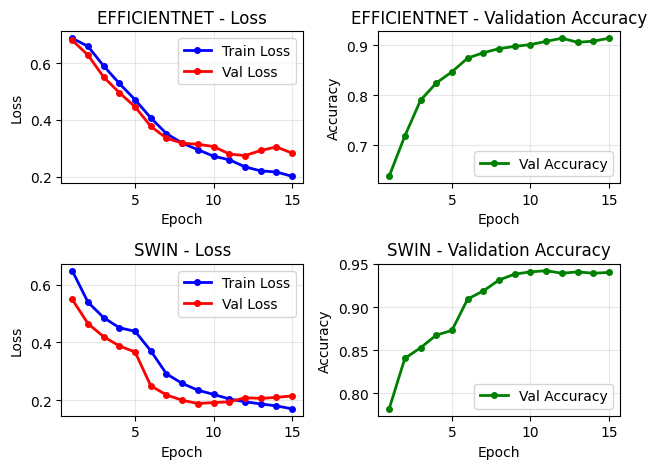


===== EPOCH 16/30 =====

Training efficientnet for Epoch 16...
  Current LRs for efficientnet:
    Group 'group_0': 8.20e-07
Epoch 16 | Batch 50/913 | Loss 0.087122
Epoch 16 | Batch 100/913 | Loss 0.163705
Epoch 16 | Batch 150/913 | Loss 0.140107
Epoch 16 | Batch 200/913 | Loss 0.171426
Epoch 16 | Batch 250/913 | Loss 0.280732
Epoch 16 | Batch 300/913 | Loss 0.159900
Epoch 16 | Batch 350/913 | Loss 0.088903
Epoch 16 | Batch 400/913 | Loss 0.263896
Epoch 16 | Batch 450/913 | Loss 0.127734
Epoch 16 | Batch 500/913 | Loss 0.224010
Epoch 16 | Batch 550/913 | Loss 0.187849
Epoch 16 | Batch 600/913 | Loss 0.088661
Epoch 16 | Batch 650/913 | Loss 0.164216
Epoch 16 | Batch 700/913 | Loss 0.129297
Epoch 16 | Batch 750/913 | Loss 0.114076
Epoch 16 | Batch 800/913 | Loss 0.212678
Epoch 16 | Batch 850/913 | Loss 0.135669
Epoch 16 | Batch 900/913 | Loss 0.351257
Validating efficientnet for Epoch 16...
RESULTS: efficientnet | Epoch 16/30 | Train Loss: 0.197871 | Val Acc: 0.905397

Training swin for

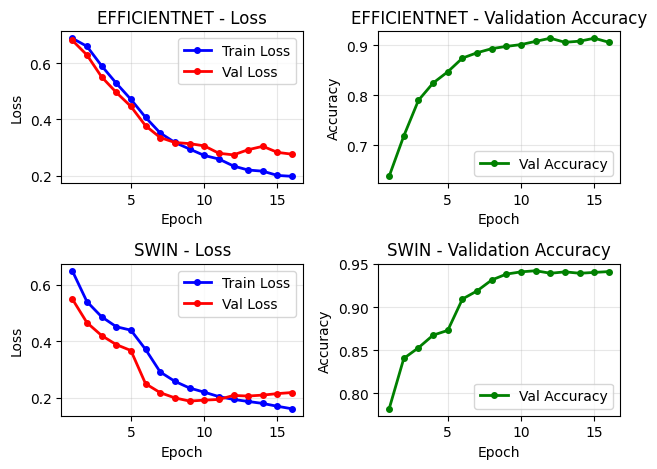


===== EPOCH 17/30 =====

Training efficientnet for Epoch 17...
  Current LRs for efficientnet:
    Group 'group_0': 8.20e-07
Epoch 17 | Batch 50/913 | Loss 0.609726
Epoch 17 | Batch 100/913 | Loss 0.200409
Epoch 17 | Batch 150/913 | Loss 0.089031
Epoch 17 | Batch 200/913 | Loss 0.121987
Epoch 17 | Batch 250/913 | Loss 0.128994
Epoch 17 | Batch 300/913 | Loss 0.117454
Epoch 17 | Batch 350/913 | Loss 0.127341
Epoch 17 | Batch 400/913 | Loss 0.509013
Epoch 17 | Batch 450/913 | Loss 0.203948
Epoch 17 | Batch 500/913 | Loss 0.065365
Epoch 17 | Batch 550/913 | Loss 0.122558
Epoch 17 | Batch 600/913 | Loss 0.113972
Epoch 17 | Batch 650/913 | Loss 0.201281
Epoch 17 | Batch 700/913 | Loss 0.151851
Epoch 17 | Batch 750/913 | Loss 0.120997
Epoch 17 | Batch 800/913 | Loss 0.164143
Epoch 17 | Batch 850/913 | Loss 0.265998
Epoch 17 | Batch 900/913 | Loss 0.105143
Validating efficientnet for Epoch 17...
RESULTS: efficientnet | Epoch 17/30 | Train Loss: 0.187972 | Val Acc: 0.902471

Training swin for

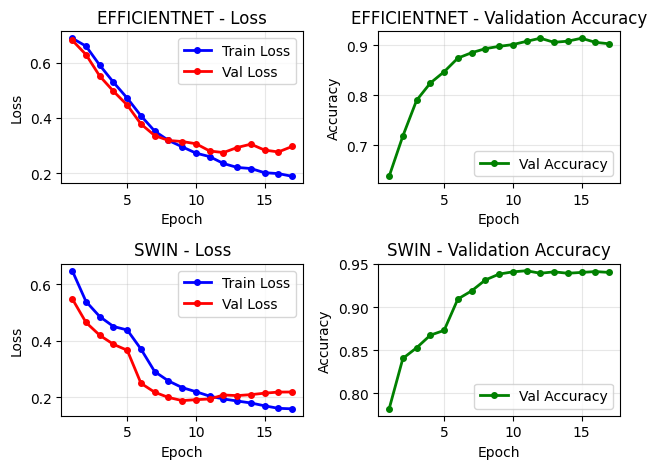


===== EPOCH 18/30 =====

Training efficientnet for Epoch 18...
  Current LRs for efficientnet:
    Group 'group_0': 8.20e-07
Epoch 18 | Batch 50/913 | Loss 0.063725
Epoch 18 | Batch 100/913 | Loss 0.080264
Epoch 18 | Batch 150/913 | Loss 0.168307
Epoch 18 | Batch 200/913 | Loss 0.058981
Epoch 18 | Batch 250/913 | Loss 0.454008
Epoch 18 | Batch 300/913 | Loss 0.478489
Epoch 18 | Batch 350/913 | Loss 0.594681
Epoch 18 | Batch 400/913 | Loss 0.122086
Epoch 18 | Batch 450/913 | Loss 0.075299
Epoch 18 | Batch 500/913 | Loss 0.085411
Epoch 18 | Batch 550/913 | Loss 0.212586
Epoch 18 | Batch 600/913 | Loss 0.123180
Epoch 18 | Batch 650/913 | Loss 0.190193
Epoch 18 | Batch 700/913 | Loss 0.104428
Epoch 18 | Batch 750/913 | Loss 0.176537
Epoch 18 | Batch 800/913 | Loss 0.574429
Epoch 18 | Batch 850/913 | Loss 0.272525
Epoch 18 | Batch 900/913 | Loss 0.120813
Validating efficientnet for Epoch 18...
RESULTS: efficientnet | Epoch 18/30 | Train Loss: 0.180363 | Val Acc: 0.915475

Training swin for

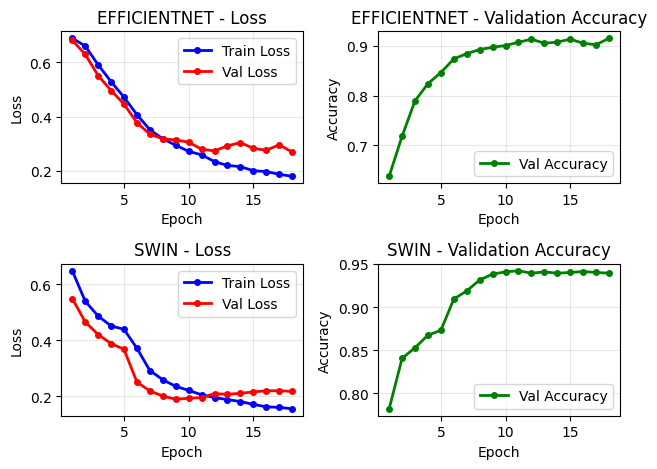


===== EPOCH 19/30 =====

Training efficientnet for Epoch 19...
  Current LRs for efficientnet:
    Group 'group_0': 8.20e-07
Epoch 19 | Batch 50/913 | Loss 0.217531
Epoch 19 | Batch 100/913 | Loss 0.267483
Epoch 19 | Batch 150/913 | Loss 0.146464
Epoch 19 | Batch 200/913 | Loss 0.100894
Epoch 19 | Batch 250/913 | Loss 0.117106
Epoch 19 | Batch 300/913 | Loss 0.168150
Epoch 19 | Batch 350/913 | Loss 0.164342
Epoch 19 | Batch 400/913 | Loss 0.136156
Epoch 19 | Batch 450/913 | Loss 0.120646
Epoch 19 | Batch 500/913 | Loss 0.080942
Epoch 19 | Batch 550/913 | Loss 0.102543
Epoch 19 | Batch 600/913 | Loss 0.182803
Epoch 19 | Batch 650/913 | Loss 0.323517
Epoch 19 | Batch 700/913 | Loss 0.077458
Epoch 19 | Batch 750/913 | Loss 0.074909
Epoch 19 | Batch 800/913 | Loss 0.094936
Epoch 19 | Batch 850/913 | Loss 0.072311
Epoch 19 | Batch 900/913 | Loss 0.205853
Validating efficientnet for Epoch 19...
RESULTS: efficientnet | Epoch 19/30 | Train Loss: 0.175322 | Val Acc: 0.914499

Training swin for

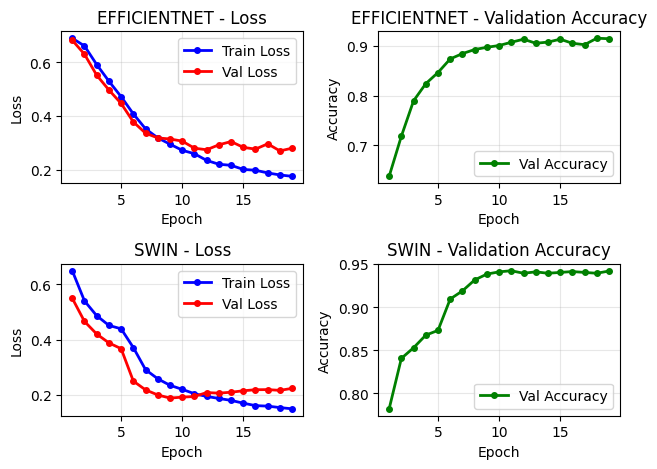


===== EPOCH 20/30 =====

Training efficientnet for Epoch 20...
  Current LRs for efficientnet:
    Group 'group_0': 8.20e-07
Epoch 20 | Batch 50/913 | Loss 0.094804
Epoch 20 | Batch 100/913 | Loss 0.070156
Epoch 20 | Batch 150/913 | Loss 0.079619
Epoch 20 | Batch 200/913 | Loss 0.083372
Epoch 20 | Batch 250/913 | Loss 0.197791
Epoch 20 | Batch 300/913 | Loss 0.068364
Epoch 20 | Batch 350/913 | Loss 0.139295
Epoch 20 | Batch 400/913 | Loss 0.240548
Epoch 20 | Batch 450/913 | Loss 0.078782
Epoch 20 | Batch 500/913 | Loss 0.084773
Epoch 20 | Batch 550/913 | Loss 0.135349
Epoch 20 | Batch 600/913 | Loss 0.355850
Epoch 20 | Batch 650/913 | Loss 0.066623
Epoch 20 | Batch 700/913 | Loss 0.194138
Epoch 20 | Batch 750/913 | Loss 0.185056
Epoch 20 | Batch 800/913 | Loss 0.131130
Epoch 20 | Batch 850/913 | Loss 0.357910
Epoch 20 | Batch 900/913 | Loss 0.201609
Validating efficientnet for Epoch 20...
RESULTS: efficientnet | Epoch 20/30 | Train Loss: 0.171261 | Val Acc: 0.910273

Training swin for

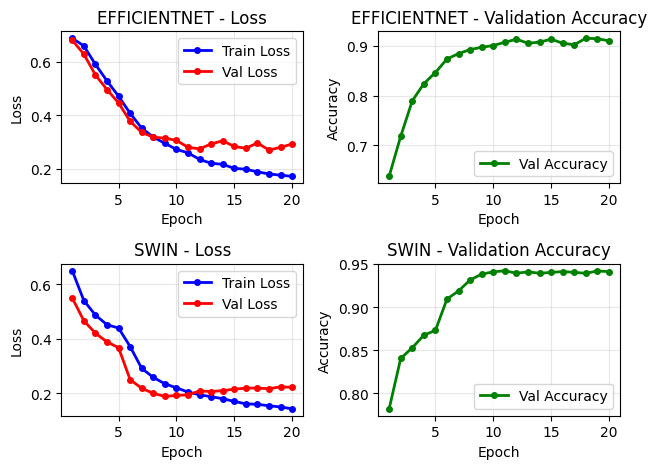


===== EPOCH 21/30 =====

Training efficientnet for Epoch 21...
  Current LRs for efficientnet:
    Group 'group_0': 8.20e-07
Epoch 21 | Batch 50/913 | Loss 0.102546
Epoch 21 | Batch 100/913 | Loss 0.080598
Epoch 21 | Batch 150/913 | Loss 0.155954
Epoch 21 | Batch 200/913 | Loss 0.066936
Epoch 21 | Batch 250/913 | Loss 0.202553
Epoch 21 | Batch 300/913 | Loss 0.181703
Epoch 21 | Batch 350/913 | Loss 0.128731
Epoch 21 | Batch 400/913 | Loss 0.117760
Epoch 21 | Batch 450/913 | Loss 0.092655
Epoch 21 | Batch 500/913 | Loss 0.060505
Epoch 21 | Batch 550/913 | Loss 0.069426
Epoch 21 | Batch 600/913 | Loss 0.117104
Epoch 21 | Batch 650/913 | Loss 0.182636
Epoch 21 | Batch 700/913 | Loss 0.069236
Epoch 21 | Batch 750/913 | Loss 0.121825
Epoch 21 | Batch 800/913 | Loss 0.098094
Epoch 21 | Batch 850/913 | Loss 0.859872
Epoch 21 | Batch 900/913 | Loss 0.324174
Validating efficientnet for Epoch 21...
RESULTS: efficientnet | Epoch 21/30 | Train Loss: 0.172417 | Val Acc: 0.911248

Training swin for

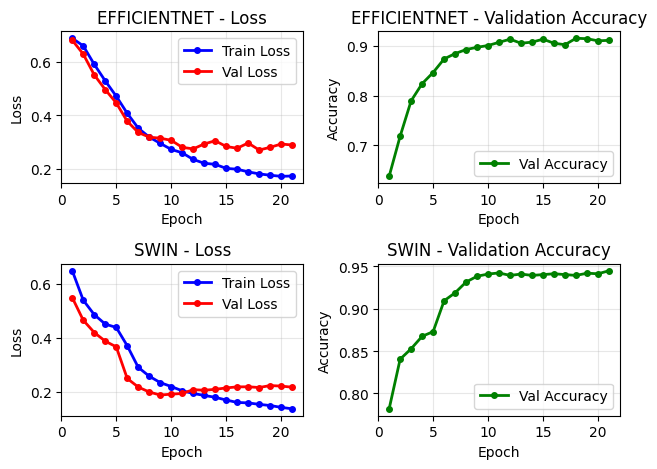


===== EPOCH 22/30 =====

Training efficientnet for Epoch 22...
  Current LRs for efficientnet:
    Group 'group_0': 8.20e-07
Epoch 22 | Batch 50/913 | Loss 0.059076
Epoch 22 | Batch 100/913 | Loss 0.091829
Epoch 22 | Batch 150/913 | Loss 0.059725
Epoch 22 | Batch 200/913 | Loss 0.069060
Epoch 22 | Batch 250/913 | Loss 0.130978
Epoch 22 | Batch 300/913 | Loss 0.067759
Epoch 22 | Batch 350/913 | Loss 0.068102
Epoch 22 | Batch 400/913 | Loss 0.240799
Epoch 22 | Batch 450/913 | Loss 0.063032
Epoch 22 | Batch 500/913 | Loss 0.130982
Epoch 22 | Batch 550/913 | Loss 0.103111
Epoch 22 | Batch 600/913 | Loss 0.159515
Epoch 22 | Batch 650/913 | Loss 0.070989
Epoch 22 | Batch 700/913 | Loss 0.124186
Epoch 22 | Batch 750/913 | Loss 0.203400
Epoch 22 | Batch 800/913 | Loss 0.075303
Epoch 22 | Batch 850/913 | Loss 0.104711
Epoch 22 | Batch 900/913 | Loss 0.314140
Validating efficientnet for Epoch 22...
RESULTS: efficientnet | Epoch 22/30 | Train Loss: 0.165942 | Val Acc: 0.917750

Training swin for

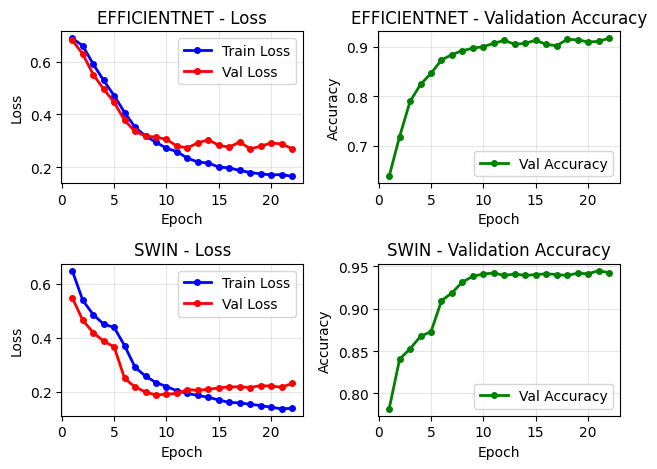


===== EPOCH 23/30 =====

Training efficientnet for Epoch 23...
  Current LRs for efficientnet:
    Group 'group_0': 8.20e-07
Epoch 23 | Batch 50/913 | Loss 0.129246
Epoch 23 | Batch 100/913 | Loss 0.064534
Epoch 23 | Batch 150/913 | Loss 0.059055
Epoch 23 | Batch 200/913 | Loss 0.093173
Epoch 23 | Batch 250/913 | Loss 0.122597
Epoch 23 | Batch 300/913 | Loss 0.108367
Epoch 23 | Batch 350/913 | Loss 0.068892
Epoch 23 | Batch 400/913 | Loss 0.171323
Epoch 23 | Batch 450/913 | Loss 0.089404
Epoch 23 | Batch 500/913 | Loss 0.246798
Epoch 23 | Batch 550/913 | Loss 0.060382
Epoch 23 | Batch 600/913 | Loss 0.092576
Epoch 23 | Batch 650/913 | Loss 0.093948
Epoch 23 | Batch 700/913 | Loss 0.057414
Epoch 23 | Batch 750/913 | Loss 0.063488
Epoch 23 | Batch 800/913 | Loss 0.182897
Epoch 23 | Batch 850/913 | Loss 0.136548
Epoch 23 | Batch 900/913 | Loss 0.118940
Validating efficientnet for Epoch 23...
RESULTS: efficientnet | Epoch 23/30 | Train Loss: 0.155138 | Val Acc: 0.916775

Training swin for

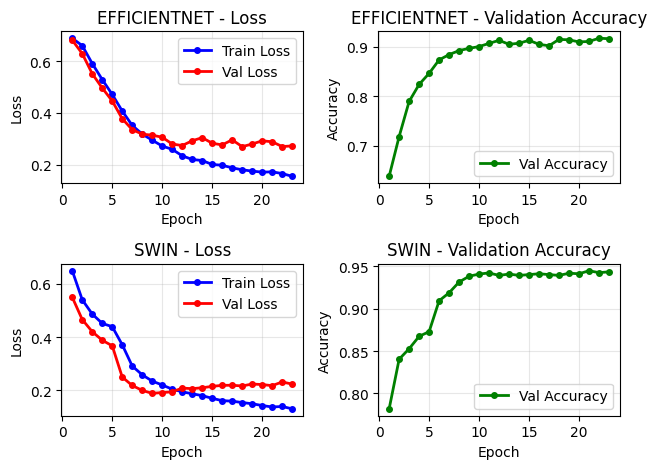


===== EPOCH 24/30 =====

Training efficientnet for Epoch 24...
  Current LRs for efficientnet:
    Group 'group_0': 8.20e-07
Epoch 24 | Batch 50/913 | Loss 0.181826
Epoch 24 | Batch 100/913 | Loss 0.062171
Epoch 24 | Batch 150/913 | Loss 0.067337
Epoch 24 | Batch 200/913 | Loss 0.059563
Epoch 24 | Batch 250/913 | Loss 0.106899
Epoch 24 | Batch 300/913 | Loss 0.185273
Epoch 24 | Batch 350/913 | Loss 0.057746
Epoch 24 | Batch 400/913 | Loss 0.095327
Epoch 24 | Batch 450/913 | Loss 0.061330
Epoch 24 | Batch 500/913 | Loss 0.074814
Epoch 24 | Batch 550/913 | Loss 0.067101
Epoch 24 | Batch 600/913 | Loss 0.398606
Epoch 24 | Batch 650/913 | Loss 0.188781
Epoch 24 | Batch 700/913 | Loss 0.853444
Epoch 24 | Batch 750/913 | Loss 0.059279
Epoch 24 | Batch 800/913 | Loss 0.064684
Epoch 24 | Batch 850/913 | Loss 0.080222
Epoch 24 | Batch 900/913 | Loss 0.059410
Validating efficientnet for Epoch 24...
RESULTS: efficientnet | Epoch 24/30 | Train Loss: 0.149830 | Val Acc: 0.916125

Training swin for

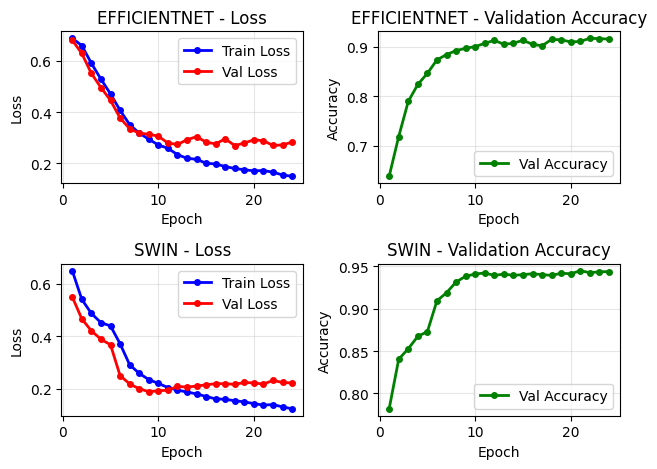


===== EPOCH 25/30 =====

Training efficientnet for Epoch 25...
  Current LRs for efficientnet:
    Group 'group_0': 8.20e-07
Epoch 25 | Batch 50/913 | Loss 0.535808
Epoch 25 | Batch 100/913 | Loss 0.225564
Epoch 25 | Batch 150/913 | Loss 0.097121
Epoch 25 | Batch 200/913 | Loss 0.064000
Epoch 25 | Batch 250/913 | Loss 0.170500
Epoch 25 | Batch 300/913 | Loss 0.084481
Epoch 25 | Batch 350/913 | Loss 0.064466
Epoch 25 | Batch 400/913 | Loss 0.127115
Epoch 25 | Batch 450/913 | Loss 0.178187
Epoch 25 | Batch 500/913 | Loss 0.133726
Epoch 25 | Batch 550/913 | Loss 0.206747
Epoch 25 | Batch 600/913 | Loss 0.071378
Epoch 25 | Batch 650/913 | Loss 0.118468
Epoch 25 | Batch 700/913 | Loss 0.235814
Epoch 25 | Batch 750/913 | Loss 0.077254
Epoch 25 | Batch 800/913 | Loss 0.070971
Epoch 25 | Batch 850/913 | Loss 0.067195
Epoch 25 | Batch 900/913 | Loss 0.356249
Validating efficientnet for Epoch 25...
RESULTS: efficientnet | Epoch 25/30 | Train Loss: 0.145447 | Val Acc: 0.913524

Training swin for

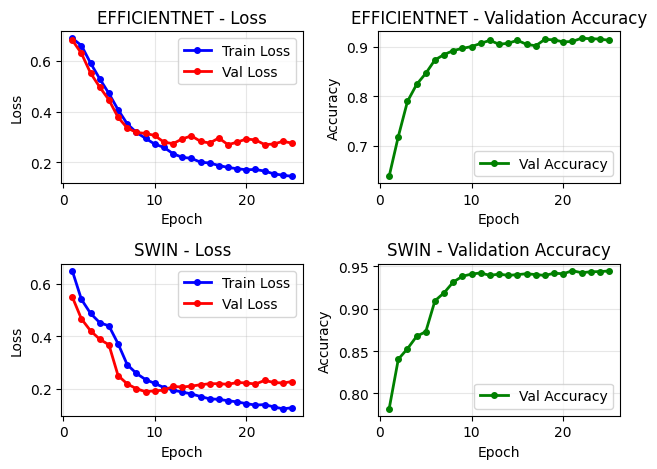


===== EPOCH 26/30 =====

Training efficientnet for Epoch 26...
  Current LRs for efficientnet:
    Group 'group_0': 8.20e-07
Epoch 26 | Batch 50/913 | Loss 0.230197
Epoch 26 | Batch 100/913 | Loss 0.203716
Epoch 26 | Batch 150/913 | Loss 0.059525
Epoch 26 | Batch 200/913 | Loss 0.126763
Epoch 26 | Batch 250/913 | Loss 0.069815
Epoch 26 | Batch 300/913 | Loss 0.098282
Epoch 26 | Batch 350/913 | Loss 0.061184
Epoch 26 | Batch 400/913 | Loss 0.167963
Epoch 26 | Batch 450/913 | Loss 0.265871
Epoch 26 | Batch 500/913 | Loss 0.285185
Epoch 26 | Batch 550/913 | Loss 0.067919
Epoch 26 | Batch 600/913 | Loss 0.064633
Epoch 26 | Batch 650/913 | Loss 0.149048
Epoch 26 | Batch 700/913 | Loss 0.097663
Epoch 26 | Batch 750/913 | Loss 0.065861
Epoch 26 | Batch 800/913 | Loss 0.126699
Epoch 26 | Batch 850/913 | Loss 0.309471
Epoch 26 | Batch 900/913 | Loss 0.061392
Validating efficientnet for Epoch 26...
RESULTS: efficientnet | Epoch 26/30 | Train Loss: 0.141010 | Val Acc: 0.921326

Training swin for

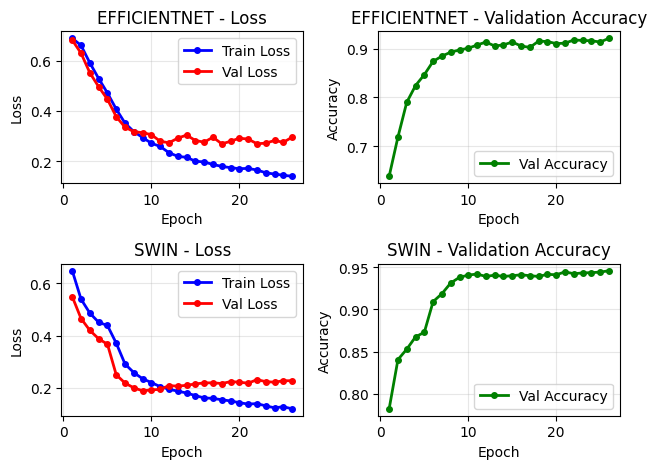


===== EPOCH 27/30 =====

Training efficientnet for Epoch 27...
  Current LRs for efficientnet:
    Group 'group_0': 8.20e-07
Epoch 27 | Batch 50/913 | Loss 0.272813
Epoch 27 | Batch 100/913 | Loss 0.503281
Epoch 27 | Batch 150/913 | Loss 0.872816
Epoch 27 | Batch 200/913 | Loss 0.076772
Epoch 27 | Batch 250/913 | Loss 0.086898
Epoch 27 | Batch 300/913 | Loss 0.159786
Epoch 27 | Batch 350/913 | Loss 0.059013
Epoch 27 | Batch 400/913 | Loss 0.076351
Epoch 27 | Batch 450/913 | Loss 0.198567
Epoch 27 | Batch 500/913 | Loss 0.058513
Epoch 27 | Batch 550/913 | Loss 0.060510
Epoch 27 | Batch 600/913 | Loss 0.102457
Epoch 27 | Batch 650/913 | Loss 0.062434
Epoch 27 | Batch 700/913 | Loss 0.105753
Epoch 27 | Batch 750/913 | Loss 0.069846
Epoch 27 | Batch 800/913 | Loss 0.198500
Epoch 27 | Batch 850/913 | Loss 0.075614
Epoch 27 | Batch 900/913 | Loss 0.074378
Validating efficientnet for Epoch 27...
RESULTS: efficientnet | Epoch 27/30 | Train Loss: 0.133144 | Val Acc: 0.913849

Training swin for

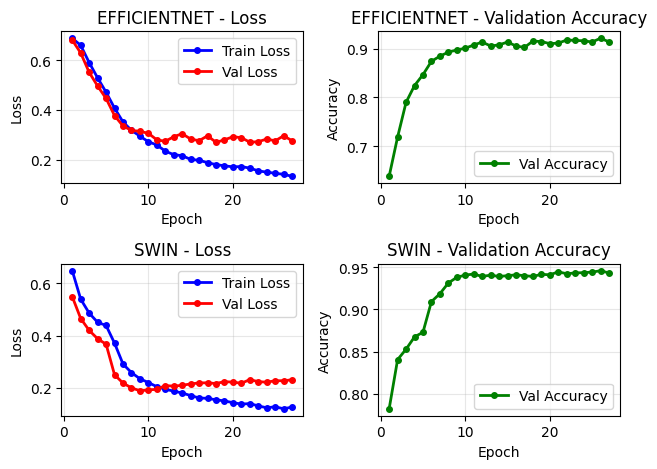


===== EPOCH 28/30 =====

Training efficientnet for Epoch 28...
  Current LRs for efficientnet:
    Group 'group_0': 8.20e-07
Epoch 28 | Batch 50/913 | Loss 0.286919
Epoch 28 | Batch 100/913 | Loss 0.070266
Epoch 28 | Batch 150/913 | Loss 0.242487
Epoch 28 | Batch 200/913 | Loss 0.103990
Epoch 28 | Batch 250/913 | Loss 0.064592
Epoch 28 | Batch 300/913 | Loss 0.059048
Epoch 28 | Batch 350/913 | Loss 0.067217
Epoch 28 | Batch 400/913 | Loss 0.074728
Epoch 28 | Batch 450/913 | Loss 0.058111
Epoch 28 | Batch 500/913 | Loss 0.062194
Epoch 28 | Batch 550/913 | Loss 0.068413
Epoch 28 | Batch 600/913 | Loss 0.123763
Epoch 28 | Batch 650/913 | Loss 0.305617
Epoch 28 | Batch 700/913 | Loss 0.062827
Epoch 28 | Batch 750/913 | Loss 0.061850
Epoch 28 | Batch 800/913 | Loss 0.067903
Epoch 28 | Batch 850/913 | Loss 0.199771
Epoch 28 | Batch 900/913 | Loss 0.062249
Validating efficientnet for Epoch 28...
RESULTS: efficientnet | Epoch 28/30 | Train Loss: 0.131426 | Val Acc: 0.916125

Training swin for

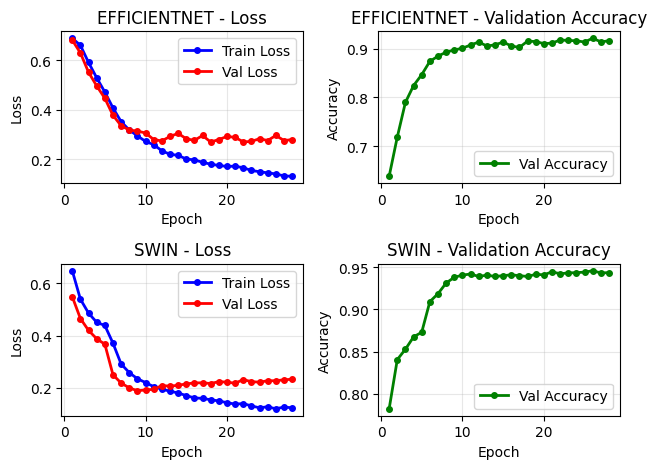


===== EPOCH 29/30 =====

Training efficientnet for Epoch 29...
  Current LRs for efficientnet:
    Group 'group_0': 8.20e-07
Epoch 29 | Batch 50/913 | Loss 0.118586
Epoch 29 | Batch 100/913 | Loss 0.282237
Epoch 29 | Batch 150/913 | Loss 0.185644
Epoch 29 | Batch 200/913 | Loss 0.181429
Epoch 29 | Batch 250/913 | Loss 0.066644
Epoch 29 | Batch 300/913 | Loss 0.078507
Epoch 29 | Batch 350/913 | Loss 0.168496
Epoch 29 | Batch 400/913 | Loss 0.059052
Epoch 29 | Batch 450/913 | Loss 0.064850
Epoch 29 | Batch 500/913 | Loss 0.162160
Epoch 29 | Batch 550/913 | Loss 0.071276
Epoch 29 | Batch 600/913 | Loss 0.058012
Epoch 29 | Batch 650/913 | Loss 0.066223
Epoch 29 | Batch 700/913 | Loss 0.064987
Epoch 29 | Batch 750/913 | Loss 0.059555
Epoch 29 | Batch 800/913 | Loss 0.069398
Epoch 29 | Batch 850/913 | Loss 0.067913
Epoch 29 | Batch 900/913 | Loss 0.081858
Validating efficientnet for Epoch 29...
RESULTS: efficientnet | Epoch 29/30 | Train Loss: 0.127757 | Val Acc: 0.910923

Training swin for

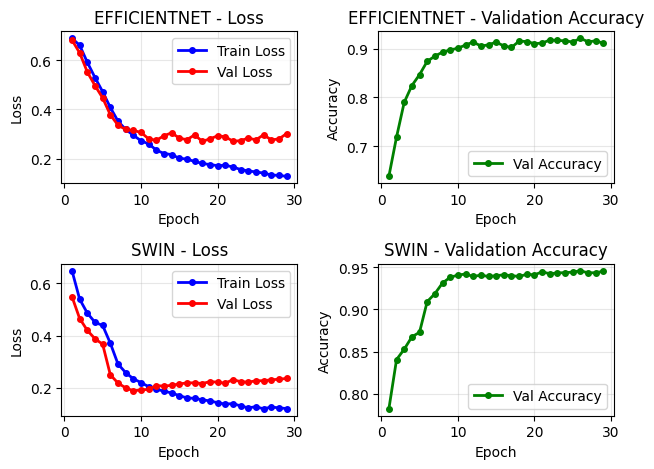


===== EPOCH 30/30 =====

Training efficientnet for Epoch 30...
  Current LRs for efficientnet:
    Group 'group_0': 8.20e-07
Epoch 30 | Batch 50/913 | Loss 0.271407
Epoch 30 | Batch 100/913 | Loss 0.063018
Epoch 30 | Batch 150/913 | Loss 0.062491
Epoch 30 | Batch 200/913 | Loss 0.333913
Epoch 30 | Batch 250/913 | Loss 0.095807
Epoch 30 | Batch 300/913 | Loss 0.508628
Epoch 30 | Batch 350/913 | Loss 0.075757
Epoch 30 | Batch 400/913 | Loss 0.155443
Epoch 30 | Batch 450/913 | Loss 0.059954
Epoch 30 | Batch 500/913 | Loss 0.067099
Epoch 30 | Batch 550/913 | Loss 0.059421
Epoch 30 | Batch 600/913 | Loss 0.090378
Epoch 30 | Batch 650/913 | Loss 0.057209
Epoch 30 | Batch 700/913 | Loss 0.266610
Epoch 30 | Batch 750/913 | Loss 0.069056
Epoch 30 | Batch 800/913 | Loss 0.058730
Epoch 30 | Batch 850/913 | Loss 0.061913
Epoch 30 | Batch 900/913 | Loss 0.061512
Validating efficientnet for Epoch 30...
RESULTS: efficientnet | Epoch 30/30 | Train Loss: 0.125368 | Val Acc: 0.920351

Training swin for

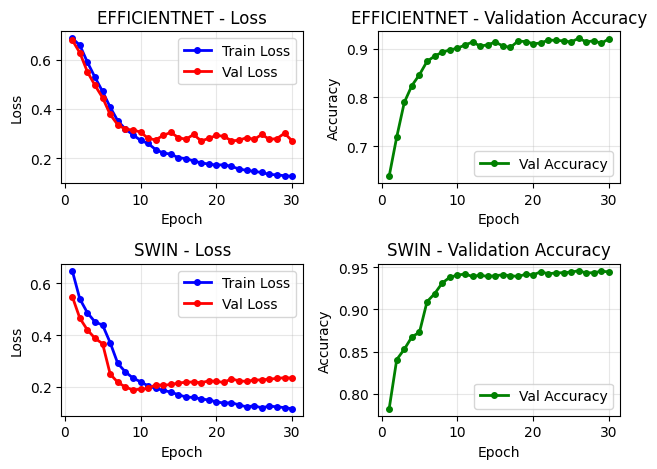


--- Saving Training Results ---
Detailed results saved to /kaggle/working/Training Data/efficientnet_results_2025-09-15_09-52-16_run1.json
Detailed results saved to /kaggle/working/Training Data/swin_results_2025-09-15_09-52-16_run1.json

--- Training complete. Results saved. ---


In [10]:
# import torch
# from timm.scheduler import CosineLRScheduler
# from datetime import datetime
# import os
# import json
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import defaultdict
import torch.optim # For torch.optim.lr_scheduler.ReduceLROnPlateau

def eval_dataset_with_loss(model, loader, loss_fn):
    model.eval()
    group_logits = defaultdict(list)
    group_labels = {}
    total_loss = 0
    total_samples = 0
    
    with torch.no_grad():
        for x, y, pid in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            
            # Calculate loss for this batch
            batch_loss = loss_fn(logits, y)
            total_loss += batch_loss.item() * x.size(0)
            total_samples += x.size(0)
            
            # Continue with painting-level aggregation
            logits_cpu = logits.cpu()
            for lg, yy, id_ in zip(logits_cpu, y.cpu(), pid):
                group_logits[id_].append(lg)
                group_labels[id_] = int(yy)

    # Calculate average loss
    avg_loss = total_loss / total_samples

    # Class balance print
    y_true = list(group_labels.values())

    # Compute painting-level accuracy
    y_pred = [int(torch.stack(lgs).mean(0).argmax()) for lgs in group_logits.values()]
    acc = sum(yt==yp for yt, yp in zip(y_true, y_pred)) / len(y_true)
    
    return acc, avg_loss

# --- ASSUMPTIONS ---
# - 'models': dictionary containing your initialized models, including models['swin']
# - 'optimizers': dictionary with optimizers. optimizers['swin'] MUST have been
#   configured with two parameter groups:
#   {'params': backbone_params, 'lr': SWIN_LR_BACKBONE_FROZEN, 'name': 'swin_backbone'}
#   {'params': head_params, 'lr': SWIN_LR_HEAD_FROZEN, 'name': 'swin_head'}
#   and backbone params initially set to requires_grad=False.
# - 'device': torch.device configured (e.g., "mps", "cuda", "cpu")
# - 'train_loader', 'val_loader': DataLoader instances
# - 'loss_fn': Your loss function (e.g., CrossEntropyLoss)
# - 'train_one_epoch': Function to train for one epoch
# - 'eval_dataset': Function to evaluate on the validation set.
# - 'save_training_results': Function to save metrics.

# --- Configuration ---
EPOCHS = 30
N_FREEZE_EPOCHS_SWIN = 5
PATIENCE_REDUCE_LR = 5
EFFNET_WARMUP_EPOCHS = 5
EFFNET_BASE_LR = 1e-6
EFFNET_WARMUP_START_FACTOR = 0.1

# Setup EfficientNet warmup scheduler
warmup_scheduler = WarmupLRScheduler(
    optimizer=optimizers['efficientnet'],
    base_lr=EFFNET_BASE_LR,
    warmup_epochs=EFFNET_WARMUP_EPOCHS,
    warmup_start_factor=EFFNET_WARMUP_START_FACTOR
)

print("--- Configuring Schedulers ---")
schedulers = {}
for name_sched in models.keys():
    if name_sched == 'swin':
        # Swin scheduler will be initialized LATER, when unfreezing
        schedulers[name_sched] = None 
        print(f"  Scheduler for '{name_sched}' will be initialized during unfreeze.")
    else: # For EfficientNet
        schedulers[name_sched] = None  # Will be set after warmup
        print(f"  EfficientNet will use warmup scheduler first, then ReduceLROnPlateau.")
print("--- Schedulers configured ---")

# Metrics and State Tracking
train_metrics = {name_metrics: [] for name_metrics in models.keys()}
val_metrics = {name_metrics: [] for name_metrics in models.keys()}
val_loss_metrics = {name_metrics: [] for name_metrics in models.keys()}

SWIN_IS_UNFROZEN = False
swin_finetune_scheduler_step_count = 0

print(f"\n--- Starting Training for {EPOCHS} Epochs ---")
# Training Loop
for epoch in range(EPOCHS):
    print(f"\n===== EPOCH {epoch + 1}/{EPOCHS} =====")

    # --- Differential Learning Rate: Unfreeze Swin Backbone & Adjust LRs ---
    if 'swin' in models and epoch == N_FREEZE_EPOCHS_SWIN and not SWIN_IS_UNFROZEN:
        print(f"\n-- Epoch {epoch + 1}: Unfreezing Swin Transformer backbone and adjusting LRs for fine-tuning. --")
        
        swin_model_to_unfreeze = models['swin']
        swin_optimizer_to_adjust = optimizers['swin']

        # 1. Set requires_grad = True for ALL Swin parameters
        print("  Setting requires_grad=True for all Swin model parameters...")
        for param_name, param in swin_model_to_unfreeze.named_parameters():
            if not param.requires_grad:
                param.requires_grad = True
        print("    All Swin model parameters set to requires_grad=True.")

        # 2. Adjust LRs in the Swin optimizer's parameter groups
        if swin_optimizer_to_adjust:
            for param_group in swin_optimizer_to_adjust.param_groups:
                group_name = param_group.get('name', 'unknown_group')
                
                # Ensure params in optimizer group also reflect requires_grad=True
                for p_opt_unfreeze in param_group['params']:
                    if not p_opt_unfreeze.requires_grad: p_opt_unfreeze.requires_grad = True

                if group_name == 'swin_backbone':
                    param_group['lr'] = swin_lr_backbone_finetune
                    print(f"  LR for Swin group '{group_name}' set to: {swin_lr_backbone_finetune:.2e}")
                elif group_name == 'swin_head':
                    param_group['lr'] = swin_lr_head_finetune
                    print(f"  LR for Swin group '{group_name}' set to: {swin_lr_head_finetune:.2e}")

            # 3. Initialize the CosineLRScheduler for Swin NOW
            print("  Initializing CosineLRScheduler for Swin fine-tuning...")
            remaining_epochs_for_swin = EPOCHS - epoch
            schedulers['swin'] = CosineLRScheduler(
                swin_optimizer_to_adjust,
                t_initial=remaining_epochs_for_swin,
                warmup_t=1,                            # 1 epoch of warmup
                warmup_lr_init=swin_lr_backbone_finetune,  # start warmup from backbone LR
                lr_min=swin_lr_min_finetune
            )
            print(f"  Swin CosineLRScheduler initialized for {remaining_epochs_for_swin} fine-tuning epochs.")
            SWIN_IS_UNFROZEN = True
            swin_finetune_scheduler_step_count = 0 # Reset step count for the new scheduler
        print("-- Swin unfreezing and LR adjustment complete. --")

    # --- Iterate through models for training and validation ---
    for model_name_loop in models.keys():
        current_model_train = models[model_name_loop]
        current_optimizer_train = optimizers[model_name_loop]
        current_scheduler_train = schedulers.get(model_name_loop) 

        print(f"\nTraining {model_name_loop} for Epoch {epoch + 1}...")
        
        # Handle EfficientNet warmup
        if model_name_loop == 'efficientnet':
            if epoch < EFFNET_WARMUP_EPOCHS:
                current_lr = warmup_scheduler.step(epoch)
                print(f"  EfficientNet warmup LR: {current_lr:.2e}")
            elif epoch == EFFNET_WARMUP_EPOCHS and schedulers['efficientnet'] is None:
                print("  Warmup complete! Switching to ReduceLROnPlateau scheduler...")
                schedulers['efficientnet'] = torch.optim.lr_scheduler.ReduceLROnPlateau(
                    current_optimizer_train, mode='min', factor=0.5, 
                    patience=PATIENCE_REDUCE_LR, verbose=True
                )
        
        if current_optimizer_train:
            print(f"  Current LRs for {model_name_loop}:")
            for i, param_group_disp in enumerate(current_optimizer_train.param_groups):
                group_display_name = param_group_disp.get('name', f'group_{i}')
                print(f"    Group '{group_display_name}': {param_group_disp['lr']:.2e}")
        
        # Select appropriate loss function
        loss_fn = loss_fn_swin if model_name_loop == 'swin' else loss_fn_effnet
        
        train_loss_epoch, _, _ = train_one_epoch(
            current_model_train,
            train_loader,
            current_optimizer_train,
            loss_fn,
            epoch,
            print_every=50
        )

        print(f"Validating {model_name_loop} for Epoch {epoch + 1}...")
        val_acc_epoch, val_loss_epoch = eval_dataset_with_loss(current_model_train, val_loader, loss_fn)

        # Scheduler step
        if current_scheduler_train:
            if model_name_loop == 'swin':
                if SWIN_IS_UNFROZEN: # Only step Swin scheduler if it's active for fine-tuning
                    current_scheduler_train.step(swin_finetune_scheduler_step_count)
            else: # For EfficientNet (ReduceLROnPlateau)
                if epoch >= EFFNET_WARMUP_EPOCHS:
                    current_scheduler_train.step(train_loss_epoch)
        
        log_message = f"RESULTS: {model_name_loop} | Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss_epoch:.6f} | Val Acc: {val_acc_epoch:.6f}"
        print(log_message)
        
        train_metrics[model_name_loop].append(train_loss_epoch)
        val_metrics[model_name_loop].append(val_acc_epoch)
        val_loss_metrics[model_name_loop].append(val_loss_epoch)

    plt.clf()  # Clear the figure
    
    for model_idx, model_name in enumerate(models.keys()):
        epochs_so_far = list(range(1, epoch + 2))
        
        # Create subplots for this model
        plt.subplot(len(models), 2, model_idx * 2 + 1)
        plt.plot(epochs_so_far, train_metrics[model_name], 'b-o', label='Train Loss', linewidth=2, markersize=4)
        plt.plot(epochs_so_far, val_loss_metrics[model_name], 'r-o', label='Val Loss', linewidth=2, markersize=4)
        plt.title(f'{model_name.upper()} - Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(len(models), 2, model_idx * 2 + 2)
        plt.plot(epochs_so_far, val_metrics[model_name], 'g-o', label='Val Accuracy', linewidth=2, markersize=4)
        plt.title(f'{model_name.upper()} - Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.draw()
    plt.pause(0.1)  # Small pause to update the plot
    
    # Increment Swin fine-tune scheduler step count at the END of the outer epoch loop
    if SWIN_IS_UNFROZEN:
        swin_finetune_scheduler_step_count += 1

# Keep the final plot displayed
plt.ioff()  # Turn off interactive mode
plt.show()

print("\n--- Saving Training Results ---")
current_timestamp_str_save = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
for model_name_save_results in models.keys():
    save_training_results(
        model_name_save_results,
        train_metrics[model_name_save_results],
        val_metrics[model_name_save_results],
        current_timestamp_str_save
    )

print("\n--- Training complete. Results saved. ---")


=== EFFICIENTNET ===
ROC‐AUC: 0.969   PR‐AUC (AP): 0.947
              precision    recall  f1-score   support

   authentic       0.90      0.94      0.92      1520
   imitation       0.94      0.90      0.92      1556

    accuracy                           0.92      3076
   macro avg       0.92      0.92      0.92      3076
weighted avg       0.92      0.92      0.92      3076



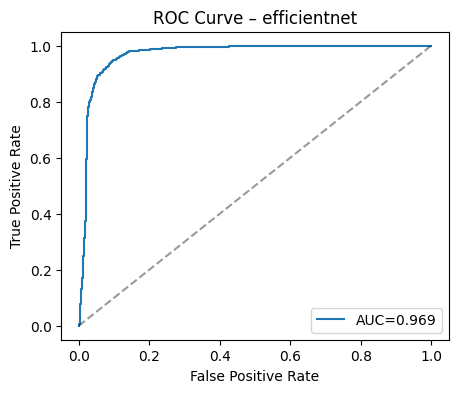

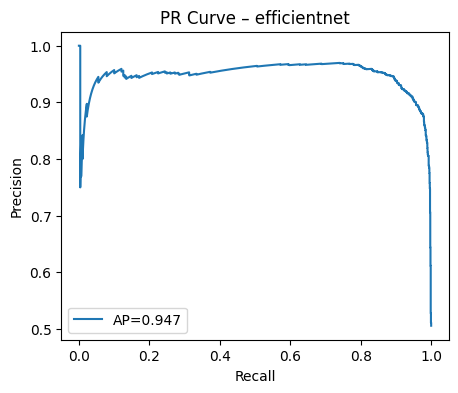


=== SWIN ===
ROC‐AUC: 0.981   PR‐AUC (AP): 0.974
              precision    recall  f1-score   support

   authentic       0.95      0.93      0.94      1520
   imitation       0.94      0.96      0.95      1556

    accuracy                           0.94      3076
   macro avg       0.95      0.94      0.94      3076
weighted avg       0.94      0.94      0.94      3076



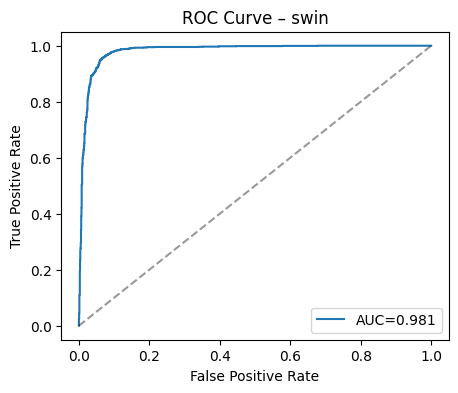

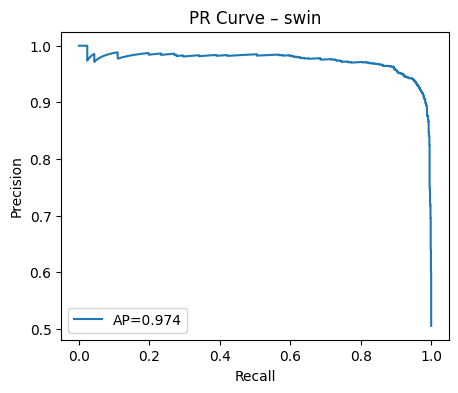

In [11]:
# 9. Detailed Evaluation Metrics & Curves
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve
)
import matplotlib.pyplot as plt
import torch.nn.functional as F

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda")

for name, model in models.items():
    model.to(device).eval()
    y_true, y_scores = [], []

    # Gather ground‐truth & predicted “imitation” probabilities
    with torch.no_grad():
        for x, y, _ in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            probs = F.softmax(logits, dim=1)[:, 1]      # P(imitation)
            y_true.extend(y.cpu().numpy().tolist())
            y_scores.extend(probs.cpu().numpy().tolist())

    # Binarize predictions at 0.5
    y_pred = [1 if p >= 0.5 else 0 for p in y_scores]

    # Compute metrics
    auc = roc_auc_score(y_true, y_scores)
    ap  = average_precision_score(y_true, y_scores)
    print(f"\n=== {name.upper()} ===")
    print(f"ROC‐AUC: {auc:.3f}   PR‐AUC (AP): {ap:.3f}")
    print(classification_report(
        y_true, y_pred,
        target_names=['authentic','imitation']
    ))

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'AUC={auc:.3f}')
    plt.plot([0,1],[0,1],'k--',alpha=0.4)
    plt.title(f'ROC Curve – {name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(); plt.show()

    # Plot Precision–Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=(5,4))
    plt.plot(recall, precision, label=f'AP={ap:.3f}')
    plt.title(f'PR Curve – {name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(); plt.show()

## 10. Plotting training metrics for each model
(reads CSV logs and plots train/val loss & val accuracy)

In [12]:
# 8) Painting‐level & Ensemble Evaluation
import numpy as np
import torch.nn.functional as F
from collections import defaultdict, Counter
from sklearn.metrics import classification_report, accuracy_score

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda")
effnet_model = models['efficientnet'].to(device).eval()
swin_model   = models['swin'].to(device).eval()

# 1. Collect patch‐level data
painting_ids, true_labels = [], []
effnet_probs, swin_probs = [], []

for x, y, pid in val_loader:
    x = x.to(device)
    with torch.no_grad():
        e_logits = effnet_model(x)
        s_logits = swin_model(x)
        e_p = F.softmax(e_logits, dim=1)[:, 1].cpu().numpy()
        s_p = F.softmax(s_logits, dim=1)[:, 1].cpu().numpy()
    painting_ids.extend(pid.numpy())
    true_labels.extend(y.numpy())
    effnet_probs.extend(e_p)
    swin_probs.extend(s_p)

# 2. Aggregate per painting
paintings = defaultdict(list)
for pid, y, p1, p2 in zip(painting_ids, true_labels, effnet_probs, swin_probs):
    paintings[pid].append((y, p1, p2))

painting_true = []
paint_eff_major = []
paint_swin_major = []
paint_ens_major = []
paint_ens_avg = []

for pid, patches in paintings.items():
    y_true = patches[0][0]
    p1_list = [t[1] for t in patches]
    p2_list = [t[2] for t in patches]
    # votes at 0.5
    v1 = [int(p>=0.5) for p in p1_list]
    v2 = [int(p>=0.5) for p in p2_list]
    # ensemble avg‐prob votes
    avg_probs = [(a+b)/2 for a,b in zip(p1_list, p2_list)]
    v_avg = [int(p>=0.5) for p in avg_probs]

    painting_true.append(y_true)
    paint_eff_major.append(Counter(v1).most_common(1)[0][0])
    paint_swin_major.append(Counter(v2).most_common(1)[0][0])
    paint_ens_major.append(Counter(v_avg).most_common(1)[0][0])
    paint_ens_avg.append(int(np.mean(avg_probs)>=0.5))

# 3. Report metrics
print("=== Painting‐level Metrics ===")
for label, preds in [
    ("EffNet‐majority", paint_eff_major),
    ("Swin‐majority", paint_swin_major),
    ("Ensemble‐majority", paint_ens_major),
    ("Ensemble‐avgprob", paint_ens_avg),
]:
    print(f"\n{label}:")
    print("Accuracy:", accuracy_score(painting_true, preds))
    print(classification_report(
        painting_true, preds,
        target_names=['authentic','imitation']
    ))

=== Painting‐level Metrics ===

EffNet‐majority:
Accuracy: 0.9601769911504425
              precision    recall  f1-score   support

   authentic       0.95      0.96      0.96       107
   imitation       0.97      0.96      0.96       119

    accuracy                           0.96       226
   macro avg       0.96      0.96      0.96       226
weighted avg       0.96      0.96      0.96       226


Swin‐majority:
Accuracy: 0.9513274336283186
              precision    recall  f1-score   support

   authentic       0.96      0.93      0.95       107
   imitation       0.94      0.97      0.95       119

    accuracy                           0.95       226
   macro avg       0.95      0.95      0.95       226
weighted avg       0.95      0.95      0.95       226


Ensemble‐majority:
Accuracy: 0.9557522123893806
              precision    recall  f1-score   support

   authentic       0.96      0.94      0.95       107
   imitation       0.95      0.97      0.96       119

    accura

## 11. Saving metrics for each model


In [13]:
import os, json
import matplotlib.pyplot as plt

for model_name in models:
    json_path = f"/kaggle/working/Training Data/{model_name}_results_{now_str}.json"
    if not os.path.exists(json_path):
        print(f"No JSON results for {model_name} at {json_path}")
        continue

    # load our JSON list of dicts
    with open(json_path) as f:
        results = json.load(f)

    train_loss = results["training"]
    val_acc    = results["validation"]
    epochs     = list(range(1, len(train_loss)+1))

    plt.plot(epochs, train_loss, label="train loss")
    plt.plot(epochs, val_acc,    label="val acc")
    plt.legend()
    plt.show()

    #epochs = [r["epoch"] for r in results["training"]]
    #train_loss = [r["loss"]  for r in results["training"]]
    #val_acc    = [r["acc"]   for r in results["validation"]]

    fig, axes = plt.subplots(1, 2, figsize=(14,5))
    ax = axes[0]
    ax.plot(epochs, train_loss, '-o', label="Train Loss")
    ax.set_title(f"{model_name} – Train Loss")
    ax.set_xlabel("Epoch"); ax.set_ylabel("Loss")
    ax.grid(True)

    ax = axes[1]
    ax.plot(epochs, val_acc, '-o', color="green", label="Val Acc")
    ax.set_title(f"{model_name} – Val Accuracy")
    ax.set_xlabel("Epoch"); ax.set_ylabel("Accuracy")
    ax.grid(True)

    plt.tight_layout()
    plt.show()

No JSON results for efficientnet at /kaggle/working/Training Data/efficientnet_results_2025-09-15_05-35-53.json
No JSON results for swin at /kaggle/working/Training Data/swin_results_2025-09-15_05-35-53.json


## 12. Saving models

In [14]:
import os
import torch

# Ensure the save directory exists
for path in model_save_paths.values():
    os.makedirs(os.path.dirname(path), exist_ok=True)

# Save each model after training
for name, model in models.items():
    torch.save(model.state_dict(), model_save_paths[name])
    print(f"Model weights saved to {model_save_paths[name]}")

Model weights saved to /kaggle/working/model/efficientnet_b5_finetuned_2025-09-15_05-35-53_run1.pth
Model weights saved to /kaggle/working/model/swin_tiny_patch4_window7_224_finetuned_2025-09-15_05-35-53_run1.pth
